In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from gseapy import barplot, dotplot, ringplot
from gseapy import Biomart
from gseapy import gseaplot, heatmap
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

30

# Global Paths

In [3]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/results/UCLA/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/UCLA/'
table_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/UCLA/'

# Data

In [4]:
# sample info
pak4ko_invitro = pd.read_csv(data_home + 'UCLA/processed/PAK4KO_in_vitro_sample.csv',
                             header=0, index_col=0, sep=',')

pak4ko_invivo = pd.read_csv(data_home + 'UCLA/processed/PAK4KO_in_vivo_sample.csv',
                             header=0, index_col=0, sep=',')
pak4i_invivo = pd.read_csv(data_home + 'UCLA/processed/PAK4i_in_vivo_sample.csv',
                             header=0, index_col=0, sep=',')

In [5]:
# finalized gene expression: log2fpkm, all-zero removed
pak4ko_invitro_expr = pd.read_csv(data_home + 'UCLA/processed/PAK4KO_in_vitro_final_expr.csv',
                                  header=0, index_col=0, sep=',')

pak4ko_invivo_expr = pd.read_csv(data_home + 'UCLA/processed/PAK4KO_in_vivo_final_expr.csv',
                                  header=0, index_col=0, sep=',')
pak4i_invivo_expr = pd.read_csv(data_home + 'UCLA/processed/PAK4i_in_vivo_final_expr.csv',
                                  header=0, index_col=0, sep=',')

In [6]:
pak4ko_invitro_expr.shape

(26686, 12)

In [7]:
pak4ko_invivo_expr.shape

(32395, 28)

In [8]:
pak4i_invivo_expr.shape

(31429, 12)

# Preprocessing

In [9]:
# convert gene ID
bm = Biomart()
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id', 'external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

In [10]:
m2h_map = m2h.dropna(axis=0, how='any')
m2h_map = m2h_map.set_index('external_gene_name')
m2h_map

,ensembl_gene_id,hsapiens_homolog_ensembl_gene,hsapiens_homolog_associated_gene_name
external_gene_name,,,
mt-Nd1,ENSMUSG00000064341,ENSG00000198888,MT-ND1
mt-Nd2,ENSMUSG00000064345,ENSG00000198763,MT-ND2
mt-Co1,ENSMUSG00000064351,ENSG00000198804,MT-CO1
mt-Co2,ENSMUSG00000064354,ENSG00000198712,MT-CO2
mt-Atp8,ENSMUSG00000064356,ENSG00000228253,MT-ATP8
...,...,...,...
a,ENSMUSG00000027596,ENSG00000101440,ASIP
Ahcy,ENSMUSG00000027597,ENSG00000101444,AHCY
Gins1,ENSMUSG00000027454,ENSG00000101003,GINS1


# Toolboxes

In [11]:
def prepare_compare(expr, grpA, grpB, label_A, label_B, n_label):
    '''
    Prepare comparison matrix for GSEA run.
    '''
    expr_A = expr[grpA]
    expr_B = expr[grpB]
    expr_merged = pd.concat([expr_A, expr_B], axis=1)
    print(expr_merged.shape)
    label_merged = [label_A] * n_label
    label_merged.extend([label_B] * n_label)
    
    return expr_merged, label_merged

In [12]:
# case pathways
case_list = ['GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN',
             'GOBP_AUTOPHAGY_OF_MITOCHONDRION',
             'GOBP_RESPONSE_TO_TYPE_I_INTERFERON']

# GSEA on mouse genes

## 1. In vitro PAK4 KO

In [13]:
pak4ko_invitro_expr

,B16_IFNG-KO62_IFNg_1,B16_IFNG-KO62_IFNg_2,B16_IFNG-KO62_IFNg_3,B16_IFNG-KO62_media_1,B16_IFNG-KO62_media_2,B16_IFNG-KO62_media_3,B16_IFNG-WT_IFNg_1,B16_IFNG-WT_IFNg_2,B16_IFNG-WT_IFNg_3,B16_IFNG-WT_media_1,B16_IFNG-WT_media_2,B16_IFNG-WT_media_3
Gene Name,,,,,,,,,,,,
0610005C13Rik,0.024030,0.074660,0.042635,0.000000,0.056271,0.069235,0.124900,0.102082,0.085835,0.028945,0.072660,0.068940
0610009B22Rik,4.158697,4.353643,4.312435,4.343187,4.312529,4.282056,4.204739,4.190057,4.231137,4.238873,4.303092,4.330064
0610009E02Rik,0.065815,0.136130,0.166676,0.182062,0.095922,0.291283,0.406344,0.368602,0.317918,0.077999,0.207406,0.581507
0610009L18Rik,1.595255,1.466837,1.351756,1.603839,1.591039,1.068076,1.147210,1.046084,1.280230,0.957009,1.026180,1.092588
0610010F05Rik,3.629496,3.355478,4.179014,3.351627,3.435437,3.385757,3.100670,3.731654,4.040171,3.062751,3.465538,3.368239
...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s85,0.043248,0.258723,0.000000,0.000000,0.254064,0.000000,0.000000,0.000000,0.318906,0.000000,0.000000,0.000000
n-R5s87,0.000000,0.309379,0.000000,0.299199,0.000000,0.000000,0.000000,0.265478,0.000000,0.000000,0.000000,0.253215
n-R5s88,0.000000,0.000000,0.000000,0.000000,0.095856,0.000000,0.127921,0.000000,0.000000,0.000000,0.000000,0.000000


### 1.1 Prepare comparison matrix

In [14]:
# media: PAK4-KO, PAK4-WT
tmp_sample = pak4ko_invitro[pak4ko_invitro['Treatment'] == 'Media']
expr_PAK4KO_media, label_PAK4KO_media = prepare_compare(expr=pak4ko_invitro_expr,
                                                        grpA=tmp_sample[tmp_sample['PAK4'] == 'KO'].index,
                                                        grpB=tmp_sample[tmp_sample['PAK4'] == 'WT'].index,
                                                        label_A='media_KO', label_B='media_WT',
                                                        n_label=3)

(26686, 6)


In [15]:
label_PAK4KO_media

['media_KO', 'media_KO', 'media_KO', 'media_WT', 'media_WT', 'media_WT']

In [16]:
# ifng: PAK4-KO, PAK4-WT
tmp_sample = pak4ko_invitro[pak4ko_invitro['Treatment'] == 'IFNg']
expr_PAK4KO_ifng, label_PAK4KO_ifng = prepare_compare(expr=pak4ko_invitro_expr,
                                                      grpA=tmp_sample[tmp_sample['PAK4'] == 'KO'].index,
                                                      grpB=tmp_sample[tmp_sample['PAK4'] == 'WT'].index,
                                                      label_A='ifng_KO', label_B='ifng_WT',
                                                      n_label=3)

(26686, 6)


In [17]:
label_PAK4KO_ifng

['ifng_KO', 'ifng_KO', 'ifng_KO', 'ifng_WT', 'ifng_WT', 'ifng_WT']

In [18]:
expr_PAK4KO_media.loc['Cxcl10', :]

B16_IFNG-KO62_media_1    2.870535
B16_IFNG-KO62_media_2    2.853265
B16_IFNG-KO62_media_3    3.596512
B16_IFNG-WT_media_1      3.242240
B16_IFNG-WT_media_2      3.357328
B16_IFNG-WT_media_3      3.054646
Name: Cxcl10, dtype: float64

In [19]:
expr_PAK4KO_ifng.loc['Cxcl10', :]

B16_IFNG-KO62_IFNg_1    9.360687
B16_IFNG-KO62_IFNg_2    9.383430
B16_IFNG-KO62_IFNg_3    9.412204
B16_IFNG-WT_IFNg_1      9.193926
B16_IFNG-WT_IFNg_2      9.280457
B16_IFNG-WT_IFNg_3      9.178644
Name: Cxcl10, dtype: float64

In [20]:
expr_PAK4KO_media.loc['B2m', :]

B16_IFNG-KO62_media_1    7.475877
B16_IFNG-KO62_media_2    7.508444
B16_IFNG-KO62_media_3    7.587856
B16_IFNG-WT_media_1      7.012092
B16_IFNG-WT_media_2      6.935185
B16_IFNG-WT_media_3      6.939502
Name: B2m, dtype: float64

In [21]:
expr_PAK4KO_ifng.loc['B2m', :]

B16_IFNG-KO62_IFNg_1    9.316178
B16_IFNG-KO62_IFNg_2    9.277622
B16_IFNG-KO62_IFNg_3    9.368209
B16_IFNG-WT_IFNg_1      8.855615
B16_IFNG-WT_IFNg_2      8.957108
B16_IFNG-WT_IFNg_3      8.891591
Name: B2m, dtype: float64

In [22]:
expr_PAK4KO_media.loc['Tap1', :]

B16_IFNG-KO62_media_1    0.732193
B16_IFNG-KO62_media_2    0.589988
B16_IFNG-KO62_media_3    0.959069
B16_IFNG-WT_media_1      0.464911
B16_IFNG-WT_media_2      0.716864
B16_IFNG-WT_media_3      0.739246
Name: Tap1, dtype: float64

In [23]:
expr_PAK4KO_media.loc['Map1lc3a', :]

B16_IFNG-KO62_media_1    3.754568
B16_IFNG-KO62_media_2    3.770469
B16_IFNG-KO62_media_3    3.722086
B16_IFNG-WT_media_1      3.621647
B16_IFNG-WT_media_2      3.617124
B16_IFNG-WT_media_3      3.734439
Name: Map1lc3a, dtype: float64

In [24]:
expr_PAK4KO_media.loc['Map1lc3b', :]

B16_IFNG-KO62_media_1    4.036294
B16_IFNG-KO62_media_2    4.257219
B16_IFNG-KO62_media_3    3.968065
B16_IFNG-WT_media_1      4.058210
B16_IFNG-WT_media_2      4.277069
B16_IFNG-WT_media_3      4.252485
Name: Map1lc3b, dtype: float64

### 1.2 Run GSEA

In [151]:
# KO vs WT in media
gsea_PAK4KO_media = gp.gsea(data=expr_PAK4KO_media,
                            gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                            cls=label_PAK4KO_media,
                            permutation_type='gene_set',
                            permutaiton_num=1000,
                            threads=16, seed=0)


In [152]:
gsea_PAK4KO_media.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GOBP_POSITIVE_REGULATION_OF_CELLULAR_RESPONSE_...,0.761765,2.08652,0,0.138708,0.103,14/28,8.12%,Nr1h4;Erfe;Nucks1;Irs1;Marcks;Ptpn1;Adipor1;Sr...
1,gsea,GOBP_MYELOID_DENDRITIC_CELL_DIFFERENTIATION,0.817884,2.06248,0,0.116515,0.155,6/18,3.43%,Tgfbr2;Itgb8;Dcstamp;Relb;Il4;Psen1
2,gsea,GOBP_SEMAPHORIN_PLEXIN_SIGNALING_PATHWAY,-0.732894,-2.0446,0.00170648,0.451811,0.184,12/44,7.33%,Plxna1;Plxnb2;Sema6d;Plxna4;Nrp1;Plxnd1;Plxnc1...
3,gsea,GOBP_RELAXATION_OF_MUSCLE,0.775327,2.04039,0,0.119104,0.222,13/23,14.56%,Akap6;Pde5a;Pde4d;Prkg1;Gucy1a1;Pik3ca;Camk2d;...
4,gsea,GOBP_CELL_FATE_COMMITMENT_INVOLVED_IN_FORMATIO...,-0.827581,-2.01776,0,0.345584,0.252,3/21,0.99%,Hoxa11;Fzd7;Fgfr1
...,...,...,...,...,...,...,...,...,...,...
3716,gsea,GOBP_RAB_PROTEIN_SIGNAL_TRANSDUCTION,-0.231791,-0.528991,0.968978,0.985526,1,6/18,22.25%,Dennd3;Rab4a;Rab9b;Rab9;Rab12;Rab4b
3717,gsea,GOBP_NEGATIVE_REGULATION_OF_TYPE_I_INTERFERON_...,-0.212428,-0.505702,0.968864,0.989423,1,3/19,15.96%,Cactin;Stat2;Oas1g
3718,gsea,GOBP_POSITIVE_REGULATION_OF_PROTEIN_SUMOYLATION,0.210567,0.495863,0.971302,0.99122,1,4/15,21.01%,Mul1;Pias1;Rwdd3;Hdac4
3719,gsea,GOBP_INTEGRIN_ACTIVATION,-0.207869,-0.486979,0.984877,0.991685,1,8/20,31.01%,Jam3;Cdh17;Fermt2;Mzb1;Pcsk5;Kif14;Fermt3;Piezo1


In [153]:
# KO vs WT in ifng
gsea_PAK4KO_ifng = gp.gsea(data=expr_PAK4KO_ifng,
                            gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                            cls=label_PAK4KO_media,
                            permutation_type='gene_set',
                            permutaiton_num=1000,
                            threads=16, seed=0)

In [154]:
gsea_PAK4KO_ifng.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GOBP_POSITIVE_REGULATION_OF_INTERLEUKIN_8_PROD...,-0.840157,-2.20284,0,0.0114934,0.006,6/37,1.47%,Afap1l2;Syk;Hspa1a;Pycard;Hspa1b;Nod1
1,gsea,GOBP_INTERLEUKIN_8_PRODUCTION,-0.795348,-2.18904,0,0.00731399,0.009,7/52,1.76%,Afap1l2;Syk;Hspa1a;Pycard;Hspa1b;Nod1;Anxa4
2,gsea,GOBP_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY,0.715637,2.08891,0,0.239955,0.181,8/33,2.23%,H2-K1;Ulbp1;Stx7;B2m;H2-T23;H2-Q4;H2-D1;Pvr
3,gsea,GOBP_RELAXATION_OF_MUSCLE,0.752439,2.08641,0.002849,0.124052,0.184,13/25,12.74%,Pde5a;Akap6;Gucy1a1;Pik3ca;Pde4d;Prkg1;Gsn;Rgs...
4,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_VIA_M...,0.731205,2.07727,0.00280899,0.0938692,0.206,6/25,1.80%,H2-K1;Ulbp1;B2m;H2-T23;H2-Q4;H2-D1
...,...,...,...,...,...,...,...,...,...,...
3711,gsea,GOBP_ACUTE_PHASE_RESPONSE,0.214821,0.522283,0.976804,0.985791,1,7/17,26.55%,Fn1;Ccl5;F2;Saa1;Il1rn;Saa2;Stat5b
3712,gsea,GOBP_INTRACILIARY_ANTEROGRADE_TRANSPORT,-0.211798,-0.497323,0.97411,0.991071,1,3/18,16.62%,Ttc26;Ift27;Ift57
3713,gsea,GOBP_SOMITOGENESIS,-0.179668,-0.486865,0.996909,0.992223,1,5/49,13.01%,Notch1;Crb2;Foxc1;Lrp6;Nrarp
3714,gsea,GOBP_REGULATION_OF_TRANSLATIONAL_ELONGATION,-0.199604,-0.46037,0.986711,0.994929,1,10/18,40.53%,Usp16;Srp9;Eif5a2;Grm5;Dph5;Eif5a;Dph1;Eif4a3;...


### 1.3 Check top pathways

In [155]:
# Media: KO vs WT
gsea_PAK4KO_media.res2d.sort_values(by='NES', ascending=False)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GOBP_POSITIVE_REGULATION_OF_CELLULAR_RESPONSE_...,0.761765,2.08652,0,0.138708,0.103,14/28,8.12%,Nr1h4;Erfe;Nucks1;Irs1;Marcks;Ptpn1;Adipor1;Sr...
1,gsea,GOBP_MYELOID_DENDRITIC_CELL_DIFFERENTIATION,0.817884,2.06248,0,0.116515,0.155,6/18,3.43%,Tgfbr2;Itgb8;Dcstamp;Relb;Il4;Psen1
3,gsea,GOBP_RELAXATION_OF_MUSCLE,0.775327,2.04039,0,0.119104,0.222,13/23,14.56%,Akap6;Pde5a;Pde4d;Prkg1;Gucy1a1;Pik3ca;Camk2d;...
5,gsea,GOBP_AEROBIC_ELECTRON_TRANSPORT_CHAIN,0.637618,1.98483,0.0026178,0.218049,0.411,30/59,16.62%,Ndufc2;Ndufb8;Uqcr10;Uqcrc2;Afg1l;mt-Co1;Sdha;...
6,gsea,GOBP_CARDIAC_EPITHELIAL_TO_MESENCHYMAL_TRANSITION,0.757395,1.96739,0.00218341,0.223709,0.478,5/22,2.42%,Tgfbr2;Tgfb3;Snai2;Eng;Jag1
7,gsea,GOBP_REGULATION_OF_ATP_BIOSYNTHETIC_PROCESS,0.774043,1.95853,0,0.209172,0.508,8/21,6.99%,Ppargc1a;Slc25a12;Ndufc2;Flcn;Il4;Bcl2l1;Prkn;...
8,gsea,GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_...,0.702994,1.9451,0.00229885,0.222726,0.583,17/29,16.16%,Ndufc2;Ndufb8;Ndufs2;Dld;Ndufs1;Ndufa8;Bdnf;Pi...
9,gsea,GOBP_POSITIVE_REGULATION_OF_LEUKOCYTE_ADHESION...,0.807015,1.94487,0,0.195301,0.584,7/17,7.38%,Capn1;Rela;Gcnt1;St3gal4;Pawr;Rhoa;Irak1
10,gsea,GOBP_NEGATIVE_REGULATION_OF_PHAGOCYTOSIS,0.752013,1.93127,0,0.206644,0.645,4/21,6.16%,Cnn2;Pip4p2;Plscr1;Fer1l5
12,gsea,GOBP_PLATELET_MORPHOGENESIS,0.753782,1.92554,0,0.200517,0.668,9/20,8.98%,Actn1;Wdr1;Srf;Myh9;Zfp385a;C1galt1c1;Tal1;Ptp...


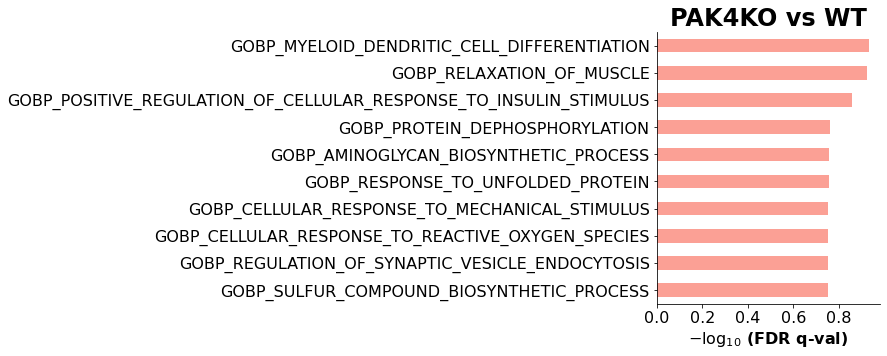

In [156]:
ax = barplot(gsea_PAK4KO_media.res2d,
             column="FDR q-val",
             title='PAK4KO vs WT',
             # cmap=plt.cm.viridis,
             size=5,
             figsize=(4,5), cutoff=0.2)

<AxesSubplot:xlabel='NES', ylabel='FDR q-val'>

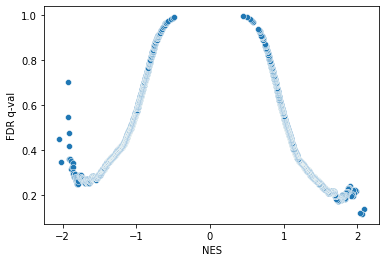

In [157]:
sns.scatterplot(x='NES', y='FDR q-val', data=gsea_PAK4KO_media.res2d)

<AxesSubplot:xlabel='NES', ylabel='NOM p-val'>

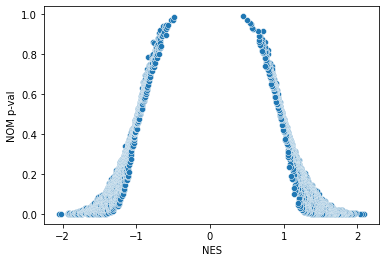

In [158]:
sns.scatterplot(x='NES', y='NOM p-val', data=gsea_PAK4KO_media.res2d)

<AxesSubplot:xlabel='FDR q-val', ylabel='NOM p-val'>

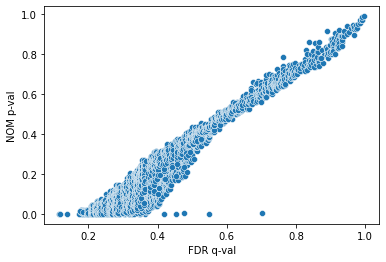

In [159]:
sns.scatterplot(x='FDR q-val', y='NOM p-val', data=gsea_PAK4KO_media.res2d)

In [164]:
gsea_PAK4KO_media.res2d.sort_values(by='NES', ascending=True)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2,gsea,GOBP_SEMAPHORIN_PLEXIN_SIGNALING_PATHWAY,-0.732894,-2.0446,0.00170648,0.451811,0.184,12/44,7.33%,Plxna1;Plxnb2;Sema6d;Plxna4;Nrp1;Plxnd1;Plxnc1...
4,gsea,GOBP_CELL_FATE_COMMITMENT_INVOLVED_IN_FORMATIO...,-0.827581,-2.01776,0,0.345584,0.252,3/21,0.99%,Hoxa11;Fzd7;Fgfr1
11,gsea,GOBP_RIBOSOMAL_LARGE_SUBUNIT_BIOGENESIS,-0.651185,-1.92871,0.0034662,0.702301,0.58,27/68,16.17%,Nop2;Nip7;Heatr3;Brix1;Mak16;Rpl10;Tma16;Pes1;...
13,gsea,GOBP_SOMATIC_STEM_CELL_POPULATION_MAINTENANCE,-0.652897,-1.92455,0,0.549224,0.595,24/64,11.59%,Kit;Lig4;Tcf7l1;Smo;Raf1;Bcl9l;Klf4;Kat6a;Nipb...
15,gsea,GOBP_PLATELET_AGGREGATION,-0.692374,-1.91744,0.00337838,0.475747,0.626,12/45,6.92%,Abat;Pdia4;Syk;Cd9;Rap2b;Ubash3b;Pdpn;Itgb3;Ce...
16,gsea,GOBP_DNA_UNWINDING_INVOLVED_IN_DNA_REPLICATION,-0.813653,-1.91176,0.00165563,0.419649,0.65,11/20,9.84%,Mcm2;Mcm5;Gins4;Wrn;Mcm3;Ssbp1;Gins2;Recql;Rec...
17,gsea,GOBP_SEMAPHORIN_PLEXIN_SIGNALING_PATHWAY_INVOL...,-0.8236,-1.91126,0.00530973,0.362217,0.654,6/16,3.44%,Plxna1;Plxnb2;Plxna4;Nrp1;Plxnd1;Plxnc1
18,gsea,GOBP_CELL_FATE_SPECIFICATION,-0.641822,-1.89903,0.00165563,0.362516,0.701,20/69,10.36%,Hoxa11;Gatad2a;Fzd7;Chd4;Tenm4;Smo;Lmo4;Fgfr1;...
21,gsea,GOBP_RIBONUCLEOPROTEIN_COMPLEX_BIOGENESIS,-0.517395,-1.88984,0,0.350378,0.738,117/402,14.70%,Ruvbl1;Strap;Wbp11;Nop2;Nip7;Heatr3;Eri1;Brix1...
22,gsea,GOBP_MATURATION_OF_5_8S_RRNA,-0.708144,-1.88919,0,0.317195,0.739,12/34,8.97%,Eri1;Mak16;Rcl1;Pes1;Bop1;Ftsj3;Npm1;Exosc3;Ex...


In [161]:
# IFNG: KO vs WT
gsea_PAK4KO_ifng.res2d.sort_values(by='NES', ascending=False)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2,gsea,GOBP_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY,0.715637,2.08891,0,0.239955,0.181,8/33,2.23%,H2-K1;Ulbp1;Stx7;B2m;H2-T23;H2-Q4;H2-D1;Pvr
3,gsea,GOBP_RELAXATION_OF_MUSCLE,0.752439,2.08641,0.002849,0.124052,0.184,13/25,12.74%,Pde5a;Akap6;Gucy1a1;Pik3ca;Pde4d;Prkg1;Gsn;Rgs...
4,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_VIA_M...,0.731205,2.07727,0.00280899,0.0938692,0.206,6/25,1.80%,H2-K1;Ulbp1;B2m;H2-T23;H2-Q4;H2-D1
8,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EN...,0.718892,1.99336,0.00297619,0.23588,0.5,7/28,1.80%,H2-K1;Ulbp1;B2m;H2-T23;H2-Q4;Tapbp;H2-D1
11,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.749434,1.97231,0.00505051,0.242309,0.573,8/20,8.83%,H2-DMb1;H2-K1;B2m;Tapbp;Mfsd6;Cd74;Traf6;Pikfyve
16,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.716054,1.94493,0.00265957,0.279042,0.67,9/26,8.83%,H2-DMb1;H2-K1;B2m;Tapbp;Mfsd6;Cd74;Traf6;Psme1...
20,gsea,GOBP_T_CELL_MEDIATED_CYTOTOXICITY,0.619788,1.92197,0.00283286,0.302693,0.728,10/42,5.22%,H2-K1;Ulbp1;Stx7;B2m;H2-T23;H2-Q4;H2-D1;Pvr;Ct...
22,gsea,GOBP_SPHINGOMYELIN_METABOLIC_PROCESS,0.725474,1.90835,0,0.308546,0.764,8/20,9.11%,Sgms2;Ormdl3;Sptlc2;Abca2;Smpdl3a;Prkcd;Smpd2;...
28,gsea,GOBP_NEGATIVE_REGULATION_OF_NIK_NF_KAPPAB_SIGN...,0.688936,1.88466,0.0129199,0.348614,0.839,9/24,12.25%,Litaf;Capn1;Rela;Uaca;Adipor1;Ndufc2;Zc3h12a;P...
33,gsea,GOBP_REGULATION_OF_SYNAPSE_ASSEMBLY,0.54064,1.86401,0,0.379491,0.886,24/97,8.62%,Mdga1;Rap2a;Ntng2;Lhfpl4;Six1;Stau2;Clstn1;Eph...


### 1.4 Specific cases

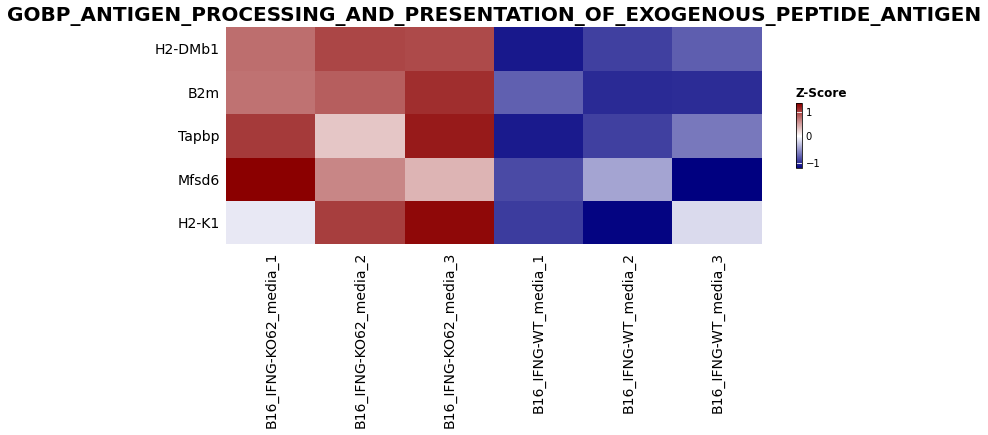

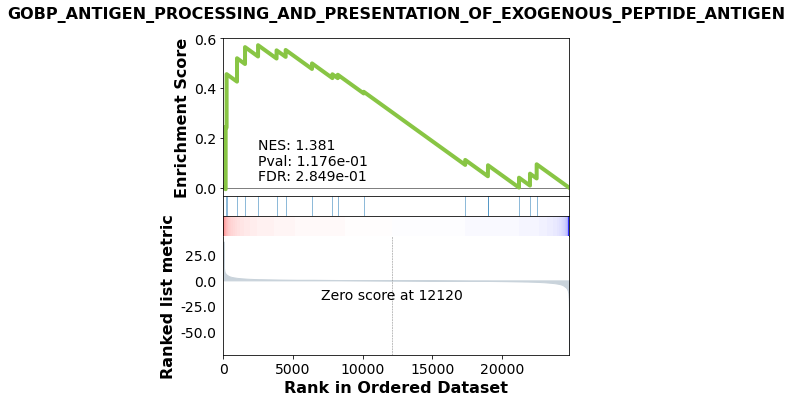

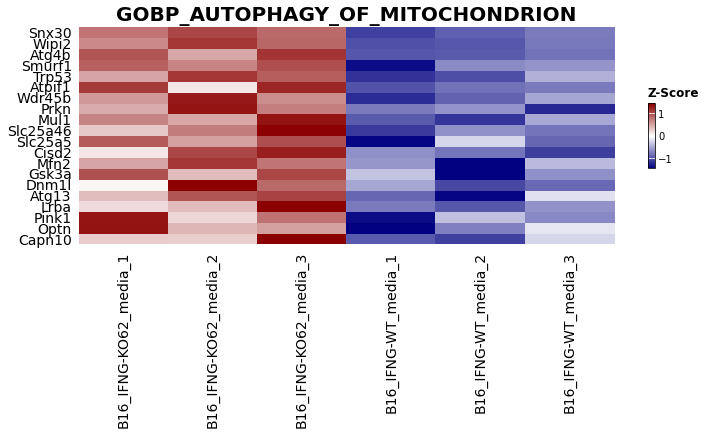

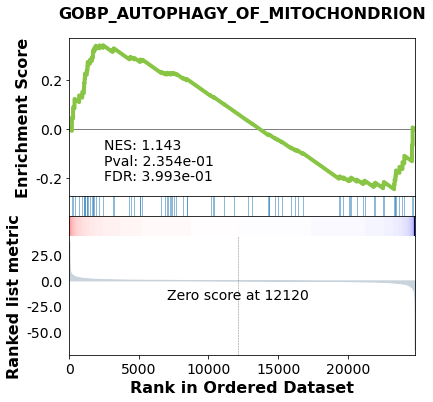

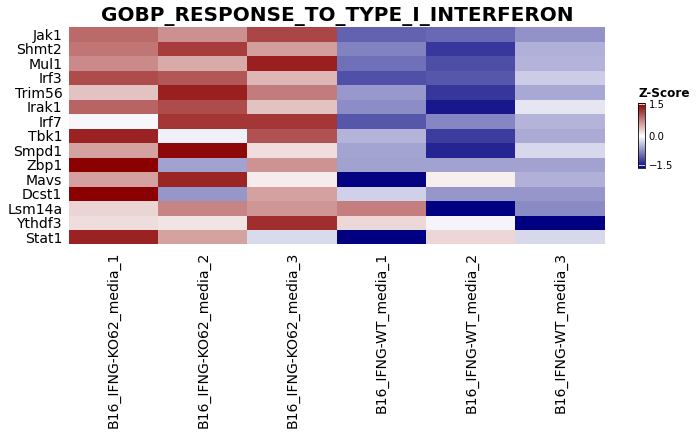

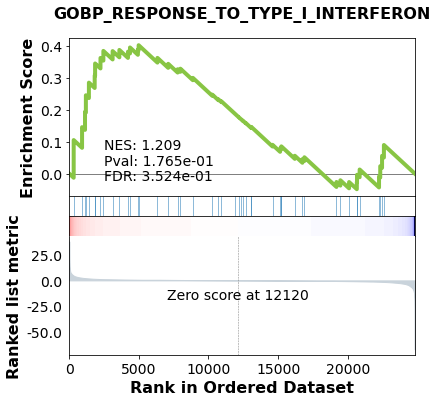

In [162]:
# media
for c in case_list:
    tmp_case = list(gsea_PAK4KO_media.res2d[gsea_PAK4KO_media.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_PAK4KO_media.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[tmp_case],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[tmp_case]])

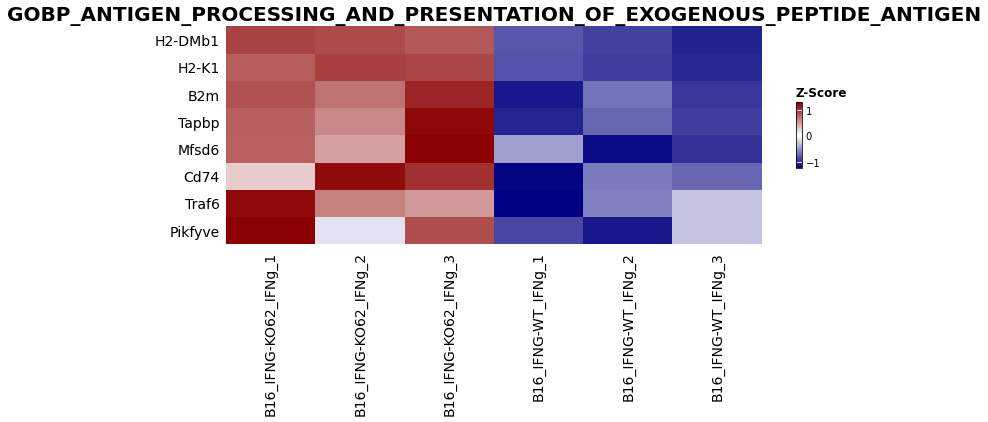

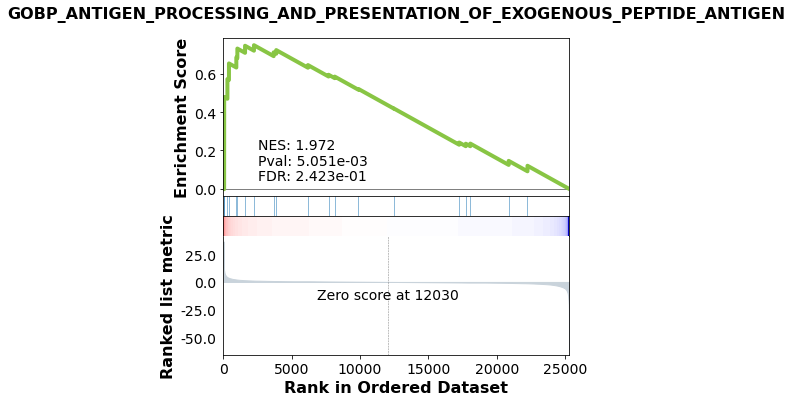

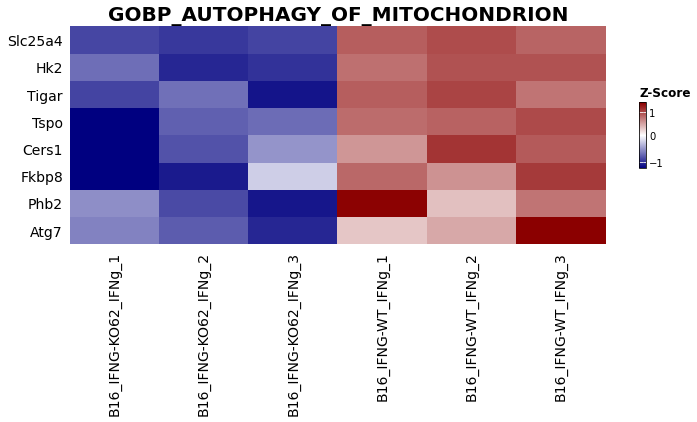

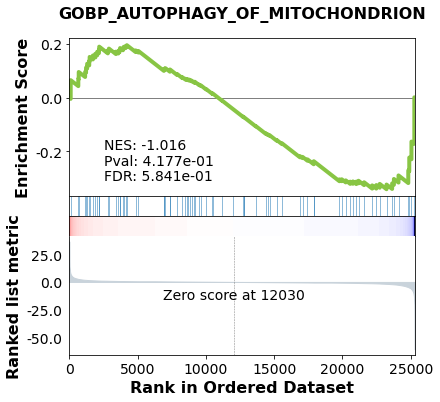

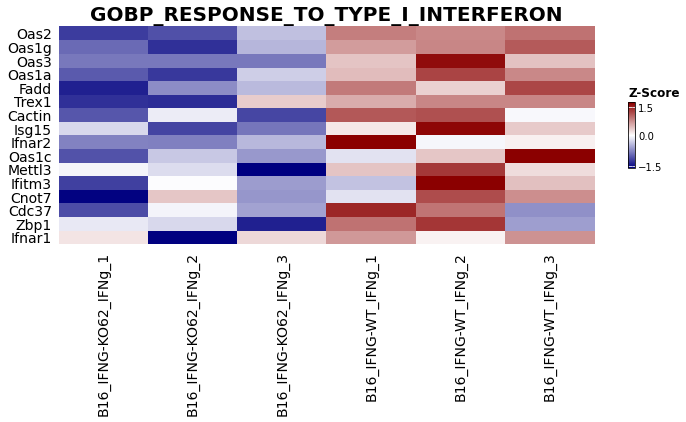

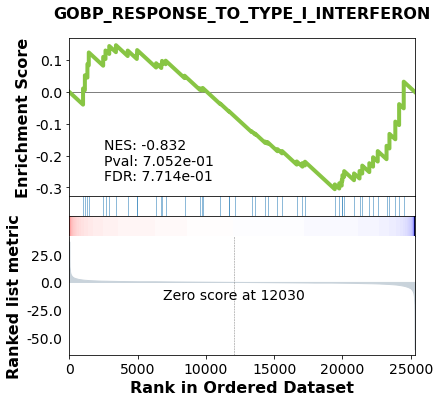

In [163]:
# IFNG
for c in case_list:
    tmp_case = list(gsea_PAK4KO_ifng.res2d[gsea_PAK4KO_ifng.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_PAK4KO_ifng.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_PAK4KO_ifng.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_PAK4KO_ifng.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_PAK4KO_ifng.ranking,
         term=gsea_PAK4KO_ifng.res2d.Term[tmp_case],
         **gsea_PAK4KO_ifng.results[gsea_PAK4KO_ifng.res2d.Term[tmp_case]])

In [ ]:
# old version

In [36]:
# Antigen presentation

In [37]:
gsea_PAK4KO_ifng.res2d[gsea_PAK4KO_ifng.res2d['Term'] == 'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
463,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.749434,1.94036,0.106667,0.375372,0.694,8/20,8.83%,H2-DMb1;H2-K1;B2m;Tapbp;Mfsd6;Cd74;Traf6;Pikfyve


In [38]:
gsea_PAK4KO_media.res2d[gsea_PAK4KO_media.res2d['Term'] == 'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
418,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.572271,1.94028,0.0981595,0.184792,0.652,7/17,18.00%,H2-DMb1;B2m;Tapbp;Mfsd6;H2-K1;H2-DMa;Traf6


<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN'}>

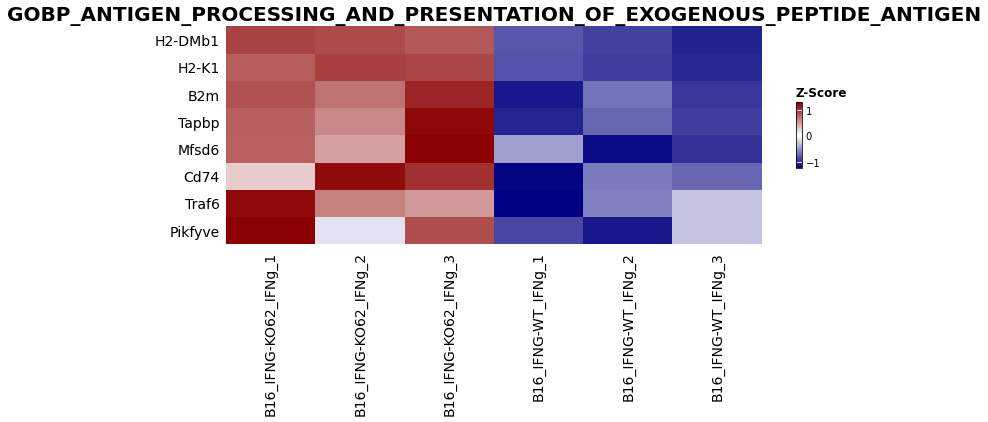

In [39]:
tmp_genes = gsea_PAK4KO_ifng.res2d.Lead_genes[463].split(';')
heatmap(df=gsea_PAK4KO_ifng.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_ifng.res2d.Term[463], figsize=(12, 4))

<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_ANTIGEN'}>

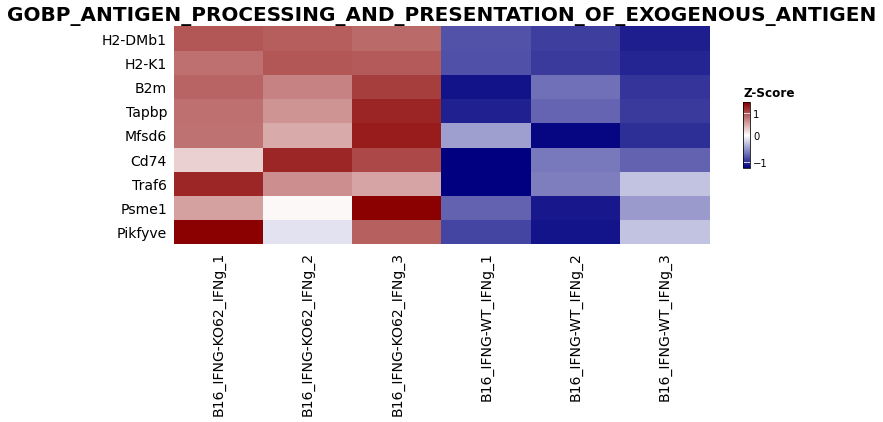

In [40]:
tmp_genes = gsea_PAK4KO_ifng.res2d.Lead_genes[368].split(';')
heatmap(df=gsea_PAK4KO_ifng.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_ifng.res2d.Term[368], figsize=(12, 4))

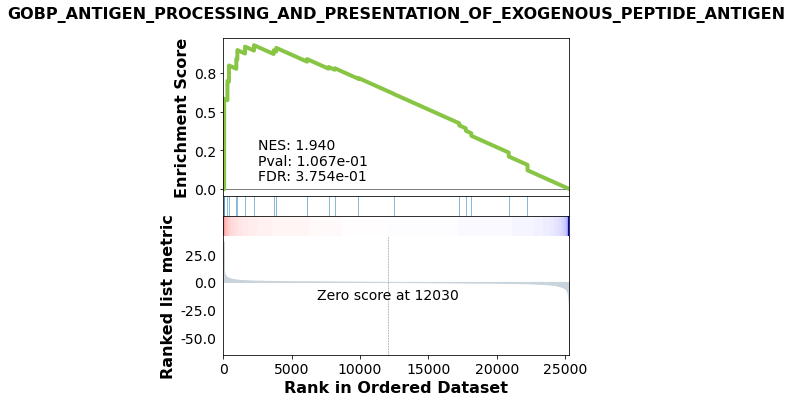

In [41]:
gseaplot(gsea_PAK4KO_ifng.ranking,
         term=gsea_PAK4KO_ifng.res2d.Term[463],
         **gsea_PAK4KO_ifng.results[gsea_PAK4KO_ifng.res2d.Term[463]])

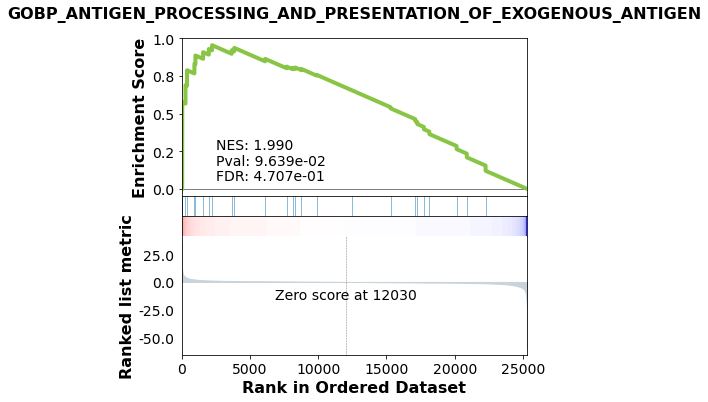

In [42]:
gseaplot(gsea_PAK4KO_ifng.ranking,
         term=gsea_PAK4KO_ifng.res2d.Term[368],
         **gsea_PAK4KO_ifng.results[gsea_PAK4KO_ifng.res2d.Term[368]])

<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN'}>

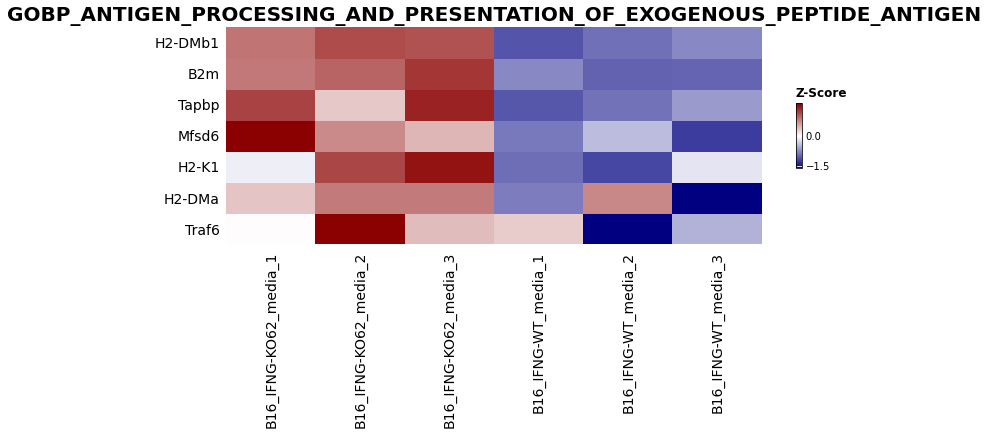

In [43]:
tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[418].split(';')
heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_media.res2d.Term[418], figsize=(12, 4))

<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_ANTIGEN'}>

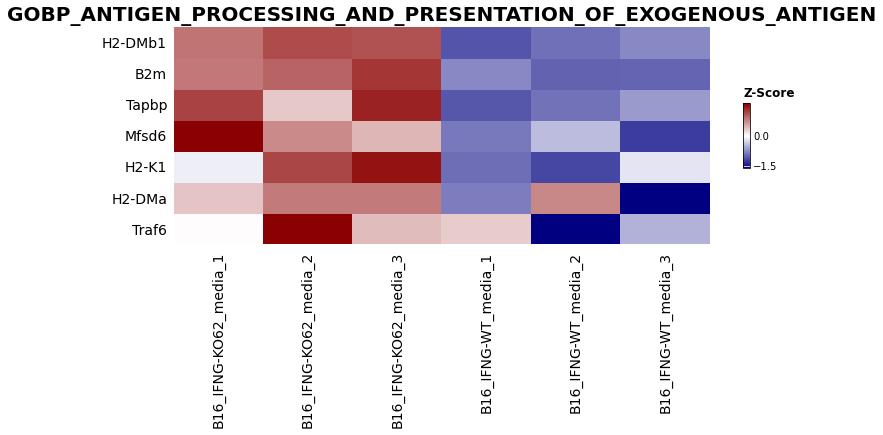

In [44]:
tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[958].split(';')
heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_media.res2d.Term[958], figsize=(12, 4))

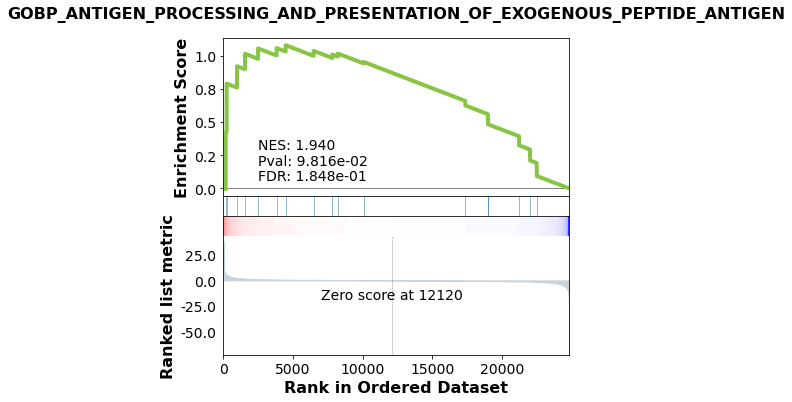

In [45]:
gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[418],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[418]])

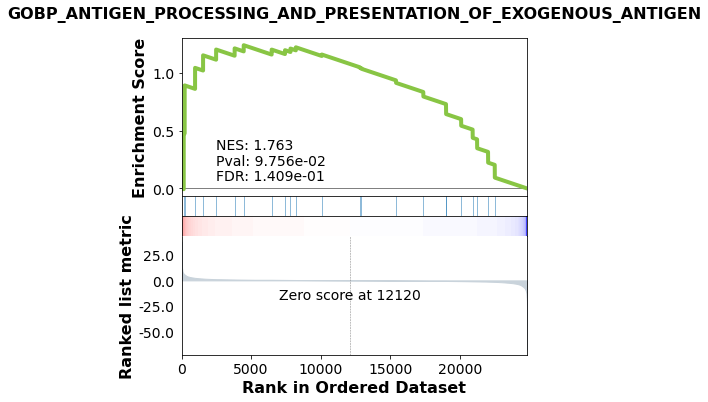

In [46]:
gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[958],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[958]])

In [47]:
# mitophagy
gsea_PAK4KO_ifng.res2d[gsea_PAK4KO_ifng.res2d['Term'] == 'GOBP_AUTOPHAGY_OF_MITOCHONDRION']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2741,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,-0.340907,-1.31669,0.205128,0.171375,1,24/79,33.24%,Slc25a4;Hk2;Tigar;Tspo;Cers1;Fkbp8;Phb2;Atg7;H...


In [48]:
# mitophagy
gsea_PAK4KO_media.res2d[gsea_PAK4KO_media.res2d['Term'] == 'GOBP_AUTOPHAGY_OF_MITOCHONDRION']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2472,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,0.342976,1.41392,0.202729,0.158127,1,40/79,34.10%,Snx30;Wipi2;Atg4b;Smurf1;Trp53;Atpif1;Wdr45b;P...


<AxesSubplot:title={'center':'GOBP_AUTOPHAGY_OF_MITOCHONDRION'}>

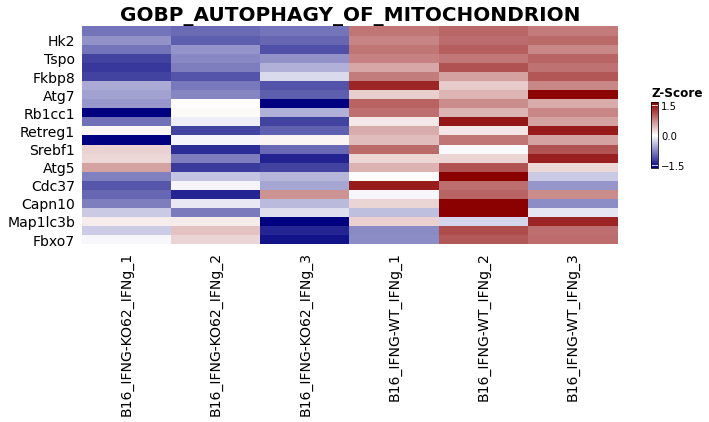

In [49]:
tmp_genes = gsea_PAK4KO_ifng.res2d.Lead_genes[2741].split(';')
heatmap(df=gsea_PAK4KO_ifng.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_ifng.res2d.Term[2741], figsize=(12, 4))

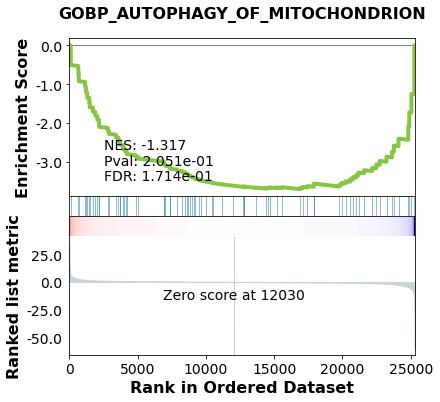

In [50]:
gseaplot(gsea_PAK4KO_ifng.ranking,
         term=gsea_PAK4KO_ifng.res2d.Term[2741],
         **gsea_PAK4KO_ifng.results[gsea_PAK4KO_ifng.res2d.Term[2741]])

<AxesSubplot:title={'center':'GOBP_AUTOPHAGY_OF_MITOCHONDRION'}>

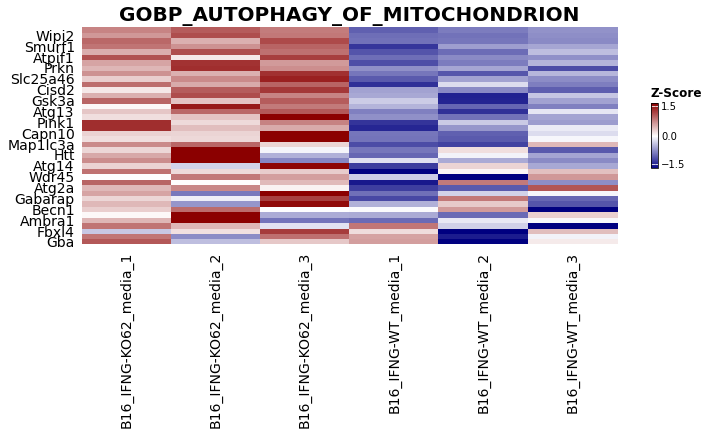

In [51]:
tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[2472].split(';')
heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_media.res2d.Term[2472], figsize=(12, 4))

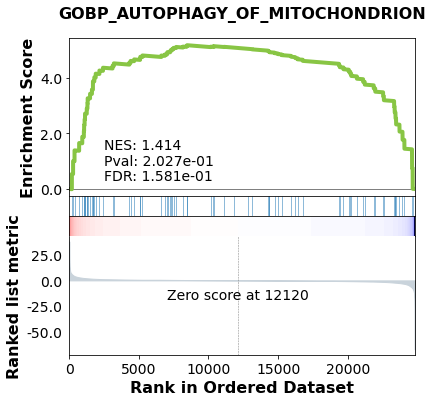

In [52]:
gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[2472],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[2472]])

In [53]:
# Type I IFN
gsea_PAK4KO_media.res2d[gsea_PAK4KO_media.res2d['Term'] == 'GOBP_RESPONSE_TO_TYPE_I_INTERFERON']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2259,gsea,GOBP_RESPONSE_TO_TYPE_I_INTERFERON,0.401894,1.46414,0.100629,0.147218,1,19/47,32.18%,Jak1;Shmt2;Mul1;Irf3;Trim56;Irak1;Irf7;Tbk1;Sm...


<AxesSubplot:title={'center':'GOBP_RESPONSE_TO_TYPE_I_INTERFERON'}>

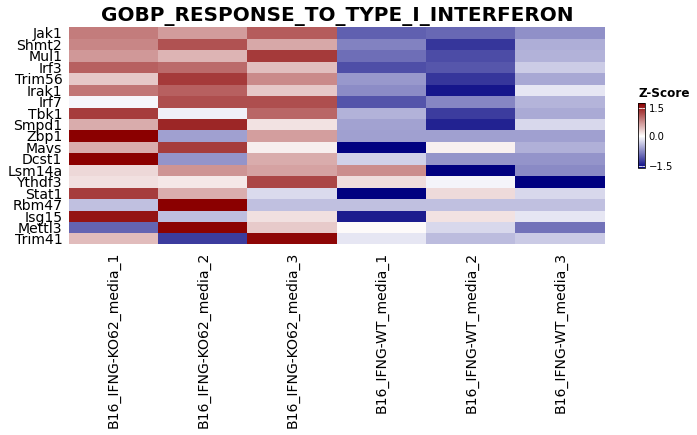

In [54]:
tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[2259].split(';')
heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_media.res2d.Term[2259], figsize=(12, 4))

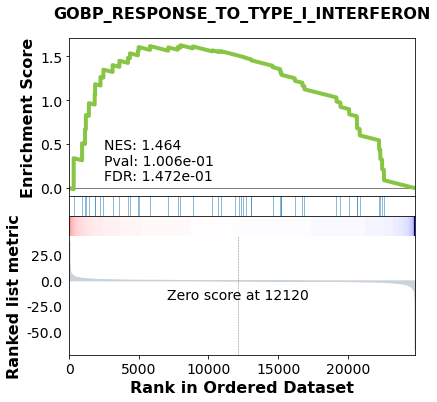

In [55]:
gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[2259],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[2259]])

In [56]:
# Type I IFN
gsea_PAK4KO_media.res2d[gsea_PAK4KO_media.res2d['Term'] == 'GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3096,gsea,GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY,0.340843,1.23901,0.265182,0.225968,1,25/57,32.18%,Jak1;Trp53;Mul1;Irf3;Trim56;Irak1;Irf7;Med1;Tb...


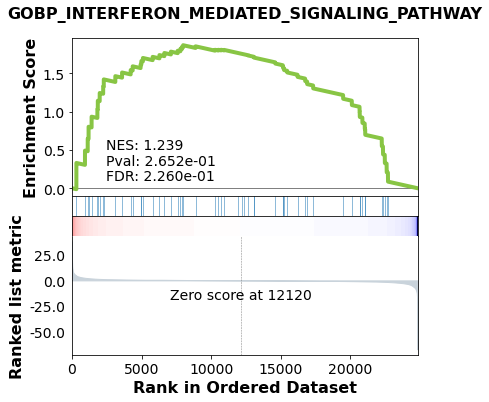

In [57]:
gseaplot(gsea_PAK4KO_media.ranking,
         term=gsea_PAK4KO_media.res2d.Term[3096],
         **gsea_PAK4KO_media.results[gsea_PAK4KO_media.res2d.Term[3096]])

<AxesSubplot:title={'center':'GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY'}>

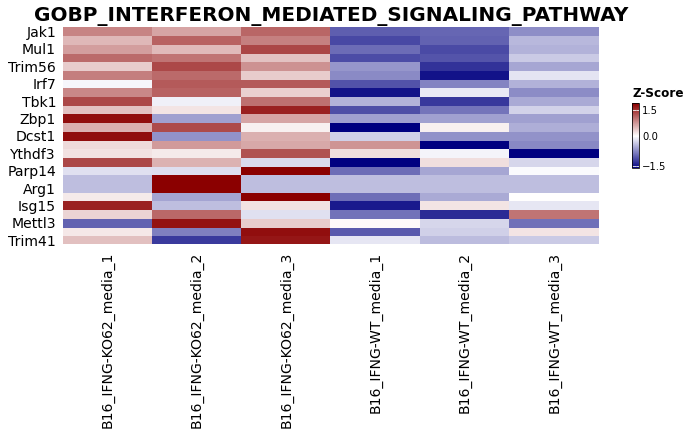

In [58]:
tmp_genes = gsea_PAK4KO_media.res2d.Lead_genes[3096].split(';')
heatmap(df=gsea_PAK4KO_media.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_media.res2d.Term[3096], figsize=(12, 4))

## 2. In vivo PAK4 KO

In [59]:
pak4ko_invivo

,Model,PAK4,Treatment,System,Day collection (invivo)
Sample,,,,,
B16_invivo_first-KO62_Isotype_1,B16,KO,Isotype,In vivo,Day 6
B16_invivo_first-KO62_Isotype_2,B16,KO,Isotype,In vivo,Day 6
B16_invivo_first-KO62_Isotype_3,B16,KO,Isotype,In vivo,Day 6
B16_invivo_first-KO62_anti-PD-1_1,B16,KO,anti-PD1,In vivo,Day 6
B16_invivo_first-KO62_anti-PD-1_2,B16,KO,anti-PD1,In vivo,Day 6
B16_invivo_first-KO62_anti-PD-1_3,B16,KO,anti-PD1,In vivo,Day 6
B16_invivo_first-WT_Isotype_1,B16,WT,Isotype,In vivo,Day 6
B16_invivo_first-WT_Isotype_2,B16,WT,Isotype,In vivo,Day 6
B16_invivo_first-WT_Isotype_3,B16,WT,Isotype,In vivo,Day 6


In [60]:
pak4ko_invivo_expr

,B16_invivo_first-KO62_Isotype_1,B16_invivo_first-KO62_Isotype_2,B16_invivo_first-KO62_Isotype_3,B16_invivo_first-KO62_anti-PD-1_1,B16_invivo_first-KO62_anti-PD-1_2,B16_invivo_first-KO62_anti-PD-1_3,B16_invivo_first-WT_Isotype_1,B16_invivo_first-WT_Isotype_2,B16_invivo_first-WT_Isotype_3,B16_invivo_first-WT_anti-PD-1_1,...,B16_invivo_last-KO62_anti-PD-1_3,B16_invivo_last-KO62_anti-PD-1_4,B16_invivo_last-WT_Isotype_1,B16_invivo_last-WT_Isotype_2,B16_invivo_last-WT_Isotype_3,B16_invivo_last-WT_Isotype_4,B16_invivo_last-WT_anti-PD-1_1,B16_invivo_last-WT_anti-PD-1_2,B16_invivo_last-WT_anti-PD-1_3,B16_invivo_last-WT_anti-PD-1_4
Gene Name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.560689,0.083307,0.138137,0.077880,0.069038,0.125217,1.057542,0.199513,0.624558,0.087476,...,0.076098,0.044139,0.361869,0.000000,0.000000,0.108073,0.254391,0.119921,0.070913,0.028959
0610006L08Rik,0.951907,0.083777,0.171601,0.000000,0.020130,0.113616,1.450901,0.318478,0.910810,0.023494,...,0.000000,0.000000,0.733201,0.033790,0.000000,0.071023,0.056135,0.130808,0.000000,0.026082
0610009B22Rik,5.122045,4.722555,4.201503,4.043920,3.681801,3.647530,4.443291,4.872194,4.914529,4.338634,...,4.023395,4.318211,5.917946,4.421795,4.482773,4.536282,4.809265,4.481282,3.846860,4.614417
0610009E02Rik,0.000000,0.615975,0.766141,0.222798,0.417977,0.315614,0.000000,0.481077,0.832181,0.329395,...,0.850902,0.184586,0.997912,0.000000,0.000000,0.187715,0.299426,1.278473,0.202978,1.057928
0610009L18Rik,3.391270,2.830354,2.509299,2.275142,2.139744,2.103835,1.358480,2.417538,2.263663,2.083654,...,2.031759,2.521725,3.152114,1.694204,1.294159,2.641131,1.652379,2.753826,1.432590,2.138715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s79,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.841468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435188,0.389327
n-R5s88,3.576929,0.943567,0.770222,0.304165,0.000000,0.658777,4.489032,1.043218,3.492593,0.000000,...,0.000000,0.000000,3.224227,0.000000,0.387021,0.334633,0.755170,1.112161,0.000000,0.000000


### 2.1 Prepare matrix

In [61]:
# iso: PAK4-KO, PAK4-WT
tmp_sample = pak4ko_invivo[pak4ko_invivo['Treatment'] == 'Isotype']
tmp_sample = tmp_sample[tmp_sample['Day collection (invivo)'] == 'day 10']
expr_PAK4KO_iso_d10, label_PAK4KO_iso_d10 = prepare_compare(expr=pak4ko_invivo_expr,
                                                            grpA=tmp_sample[tmp_sample['PAK4'] == 'KO'].index,
                                                            grpB=tmp_sample[tmp_sample['PAK4'] == 'WT'].index,
                                                            label_A='ISO_KO', label_B='ISO_WT', n_label=4)

(32395, 8)


In [62]:
# aPD1: PAK4-KO, PAK4-WT
tmp_sample = pak4ko_invivo[pak4ko_invivo['Treatment'] == 'anti-PD1']
tmp_sample = tmp_sample[tmp_sample['Day collection (invivo)'] == 'day 10']
expr_PAK4KO_aPD1_d10, label_PAK4KO_aPD1_d10 = prepare_compare(expr=pak4ko_invivo_expr,
                                                              grpA=tmp_sample[tmp_sample['PAK4'] == 'KO'].index,
                                                              grpB=tmp_sample[tmp_sample['PAK4'] == 'WT'].index,
                                                              label_A='aPD1_KO', label_B='aPD1_WT', n_label=4)

(32395, 8)


In [63]:
# WT: aPD1, None (positive control)
tmp_sample = pak4ko_invivo[pak4ko_invivo['PAK4'] == 'WT']
tmp_sample = tmp_sample[tmp_sample['Day collection (invivo)'] == 'day 10']
expr_PAK4WT_aPD1_d10, label_PAK4WT_aPD1_d10 = prepare_compare(expr=pak4ko_invivo_expr,
                                                              grpA=tmp_sample[tmp_sample['Treatment'] == 'anti-PD1'].index,
                                                              grpB=tmp_sample[tmp_sample['Treatment'] == 'Isotype'].index,
                                                              label_A='aPD1', label_B='ISO', n_label=4)

(32395, 8)


### 2.2 Run GSEA

In [165]:
# iso: PAK4-KO, PAK4-WT
gsea_PAK4KO_iso_d10 = gp.gsea(data=expr_PAK4KO_iso_d10,
                              gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                              cls=label_PAK4KO_iso_d10,
                              permutation_type='gene_set',
                              permutaiton_num=1000,
                              threads=16, seed=0)

In [166]:
gc.collect()

20

In [167]:
# aPD1: PAK4-KO, PAK4-WT
gsea_PAK4KO_aPD1_d10 = gp.gsea(data=expr_PAK4KO_aPD1_d10,
                              gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                              cls=label_PAK4KO_aPD1_d10,
                              permutation_type='gene_set',
                              permutaiton_num=1000,
                              threads=16, seed=0)

In [168]:
gc.collect()

20

In [169]:
# WT: aPD1, None (positive control)
gsea_PAK4WT_aPD1_d10 = gp.gsea(data=expr_PAK4WT_aPD1_d10,
                               gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                               cls=label_PAK4WT_aPD1_d10,
                               permutation_type='gene_set',
                               permutaiton_num=1000,
                               threads=16, seed=0)

In [170]:
gc.collect()

20

### 2.3 Top pathways

In [171]:
# WT: aPD1, None (positive control)
gsea_PAK4WT_aPD1_d10.res2d.sort_values(by='NES', ascending=False)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3,gsea,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,0.524119,2.97901,0,0,0,216/414,20.46%,Ubash3a;Pik3ap1;Nlrp1b;Cd300ld3;Esr1;Syk;Rab7b...
4,gsea,GOBP_TYPE_II_INTERFERON_PRODUCTION,0.598913,2.97494,0,0,0,70/121,19.31%,Arid5a;Cd244a;Ptpn22;Crtam;Foxp3;Itk;Havcr2;Ru...
9,gsea,GOBP_IMMUNE_RESPONSE_REGULATING_SIGNALING_PATHWAY,0.523204,2.94218,0,0,0,182/351,20.70%,Ubash3a;Pik3ap1;Nlrp1b;Cd300ld3;Esr1;Syk;Rab7b...
10,gsea,GOBP_ACTIVATION_OF_INNATE_IMMUNE_RESPONSE,0.543312,2.92471,0,0,0,118/218,20.20%,Pik3ap1;Nlrp1b;Cd300ld3;Esr1;Syk;Rab7b;Ptpn22;...
11,gsea,GOBP_REGULATION_OF_INNATE_IMMUNE_RESPONSE,0.519611,2.91952,0,0,0,179/346,20.39%,Pparg;Pik3ap1;Nlrp1b;Dcst1;Cd300ld3;Adam8;Esr1...
12,gsea,GOBP_ALPHA_BETA_T_CELL_ACTIVATION,0.561783,2.90115,0,0,0,98/175,20.44%,Il2ra;Syk;Cd244a;Ptpn22;Crtam;Foxp3;Itk;Runx3;...
13,gsea,GOBP_POSITIVE_REGULATION_OF_ALPHA_BETA_T_CELL_...,0.64933,2.89569,0,0,0,48/71,20.44%,Syk;Cd244a;Ptpn22;Foxp3;Runx3;Ripk2;Nckap1l;Ru...
14,gsea,GOBP_POSITIVE_REGULATION_OF_CYTOKINE_PRODUCTION,0.507047,2.87735,0,0,0,232/458,20.77%,Naip5;Tigit;Tbc1d23;Nlrp1b;Adam8;Syk;Rab7b;Ari...
15,gsea,GOBP_POSITIVE_REGULATION_OF_RESPONSE_TO_BIOTIC...,0.515429,2.85899,0,0,0,157/304,20.20%,Pik3ap1;Nlrp1b;Cd300ld3;Adam8;Esr1;Syk;Rab7b;N...
16,gsea,GOBP_REGULATION_OF_RESPONSE_TO_BIOTIC_STIMULUS,0.504978,2.85718,0,0,0,219/427,20.42%,Pparg;Pik3ap1;Nlrp1b;Dcst1;Cd300ld3;Adam8;Esr1...


In [172]:
# iso: PAK4-KO, PAK4-WT
gsea_PAK4KO_iso_d10.res2d.sort_values(by='NES', ascending=False)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GOBP_AEROBIC_ELECTRON_TRANSPORT_CHAIN,0.654925,3.33045,0,0,0,28/63,9.98%,Sdhd;Cox8a;Cox7a1;Uqcrfs1;Cox7a2;Uqcr11;Ndufs8...
1,gsea,GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS,0.654248,3.27044,0,0,0,34/66,10.54%,Sdhd;Atp5o;Atp5g3;Ndufb11;Atp5g1;Ndufs8;Ndufc2...
2,gsea,GOBP_OXIDATIVE_PHOSPHORYLATION,0.512036,3.02844,0,0,0,50/135,10.54%,Sdhd;Atp5o;Cox8a;Cox7a1;Uqcrfs1;Cox7a2;Uqcr11;...
3,gsea,GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT,0.570099,3.02063,0,0,0,30/77,9.98%,Sdhd;Cox8a;Cox7a1;Uqcrfs1;Cox7a2;Uqcr11;Ndufs8...
4,gsea,GOBP_ATP_BIOSYNTHETIC_PROCESS,0.476064,2.61944,0,3.96525e-05,0.001,36/96,10.54%,Sdhd;Atp5o;Atp5g3;Ndufb11;Atp5g1;Ndufs8;Ndufc2...
5,gsea,GOBP_ELECTRON_TRANSPORT_CHAIN,0.462235,2.6019,0,3.30437e-05,0.001,33/107,9.98%,Sdhd;Cox8a;Cox7a1;Uqcrfs1;Cox7a2;Uqcr11;Ndufs8...
6,gsea,GOBP_AEROBIC_RESPIRATION,0.42097,2.58537,0,2.83232e-05,0.001,51/178,9.98%,Sdhd;Atp5o;Cox8a;Cox7a1;Uqcrfs1;Cox7a2;Uqcr11;...
7,gsea,GOBP_NADH_DEHYDROGENASE_COMPLEX_ASSEMBLY,0.494956,2.43558,0,0.000198262,0.008,21/57,10.54%,Ndufb11;Ndufs8;Ndufc2;Ndufc1;Ndufa13;Ndufa1;Nd...
8,gsea,GOBP_NUCLEOSIDE_TRIPHOSPHATE_BIOSYNTHETIC_PROCESS,0.417899,2.42197,0,0.000176233,0.008,39/118,10.54%,Sdhd;Atp5o;Atp5g3;Ndufb11;Atp5g1;Ndufs8;Ndufc2...
11,gsea,GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_CYTOCHRO...,0.658346,2.33021,0,0.000436177,0.021,9/18,9.32%,Cox8a;Cox7a1;Cox7a2;Cox7c;Cox6a1;Cox6c;Cox5a;C...


In [173]:
# aPD1: PAK4-KO, PAK4-WT
gsea_PAK4KO_aPD1_d10.res2d.sort_values(by='NES', ascending=False)[:30]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
1,gsea,GOBP_AMEBOIDAL_TYPE_CELL_MIGRATION,0.454936,2.58903,0,0,0,237/425,31.98%,Agt;Sema7a;Mta2;Atp5a1;Glul;Pak3;Gpi1;Acta2;Sh...
2,gsea,GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_MI...,0.51908,2.58208,0,0,0,95/153,31.37%,Agt;Atp5a1;Gpi1;Gpld1;Epb41l4b;Atp5b;Angpt4;Ak...
3,gsea,GOBP_TRICARBOXYLIC_ACID_CYCLE,0.713184,2.56169,0,0,0,15/30,10.13%,Aco2;Mdh2;Csl;Idh3a;Dlat;Cs;Mdh1;Sucla2;Idh2;S...
4,gsea,GOBP_NEGATIVE_REGULATION_OF_PHOSPHATIDYLINOSIT...,0.829449,2.51724,0,0,0,8/15,7.09%,Obscn;Serpine2;Slc9a3r2;Slc9a3r1;Twist1;Inpp5e...
6,gsea,GOBP_REGULATION_OF_EPITHELIAL_CELL_MIGRATION,0.475573,2.49783,0,0,0,137/230,32.71%,Agt;Atp5a1;Glul;Gpi1;Sh3bp1;Gpld1;Epb41l4b;Atp...
7,gsea,GOBP_POSITIVE_REGULATION_OF_LIPID_BIOSYNTHETIC...,0.545582,2.49623,0,0,0,36/89,14.53%,Agt;Mfsd2a;Prkcd;Avpr1a;Gpld1;Sec14l2;Erbb4;St...
8,gsea,GOBP_TISSUE_MIGRATION,0.452365,2.47265,0,0,0,173/299,32.71%,Agt;Atp5a1;Glul;Gpi1;Sh3bp1;Gpld1;Epb41l4b;Atp...
9,gsea,GOBP_MONOSACCHARIDE_METABOLIC_PROCESS,0.458658,2.4674,0,0,0,84/251,15.20%,Pdk2;Fam3a;Eno1;Got1;Mdh2;Slc25a12;Eno1b;Dlat;...
10,gsea,GOBP_GLUCOSE_METABOLIC_PROCESS,0.475503,2.45986,0,0,0,61/195,11.28%,Pdk2;Fam3a;Eno1;Got1;Mdh2;Slc25a12;Eno1b;Dlat;...
11,gsea,GOBP_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS,0.479409,2.4484,0,0,0,58/168,14.53%,Acadvl;Agt;Fam3a;Mfsd2a;Prkcd;Avpr1a;Fitm2;Gpl...


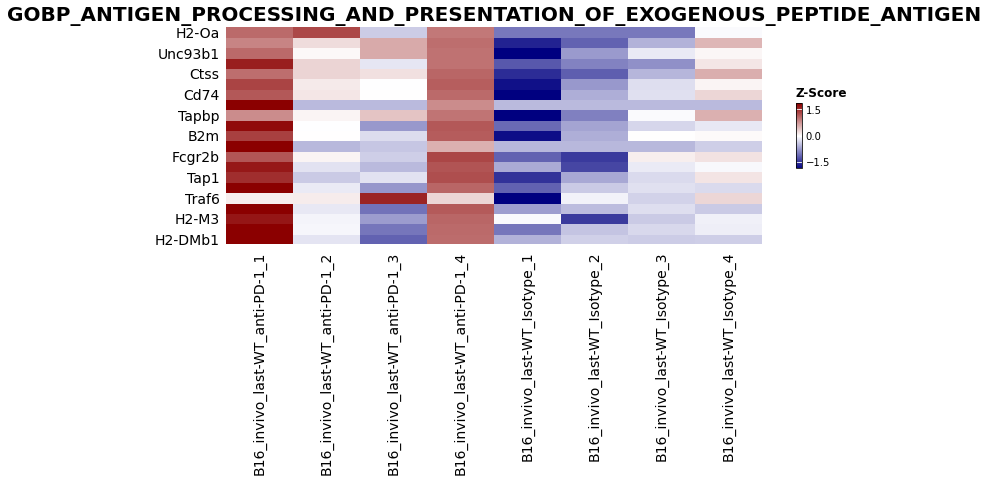

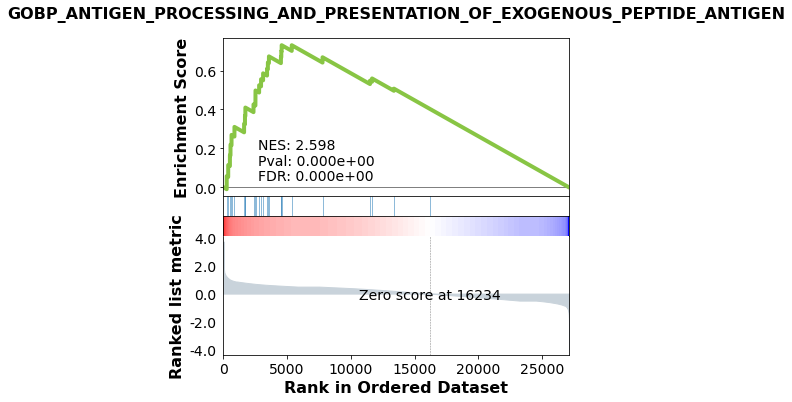

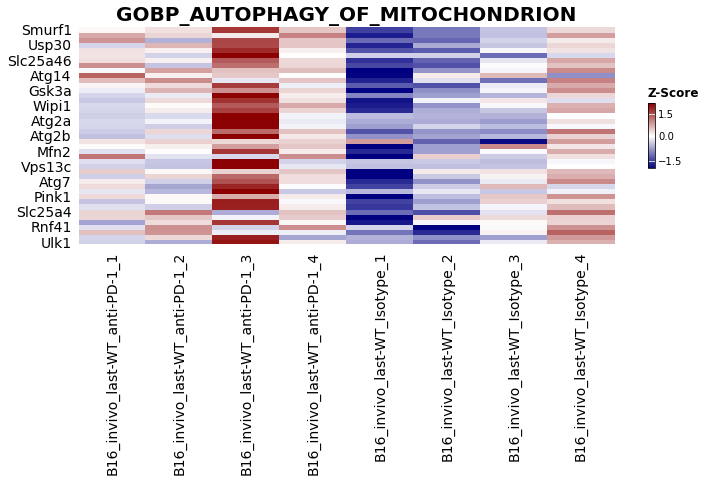

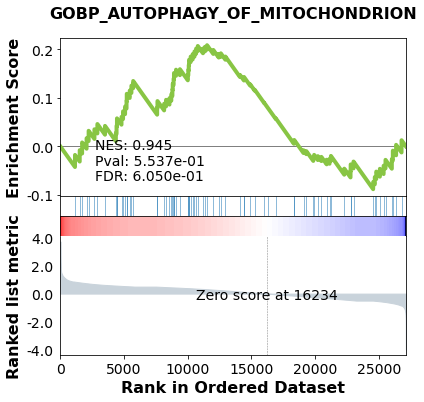

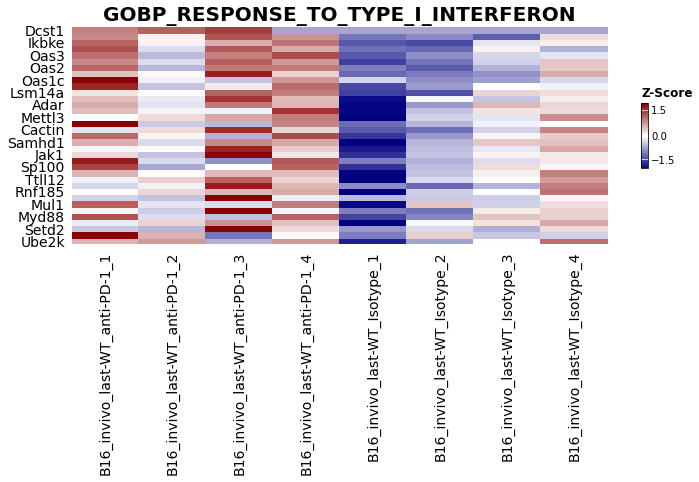

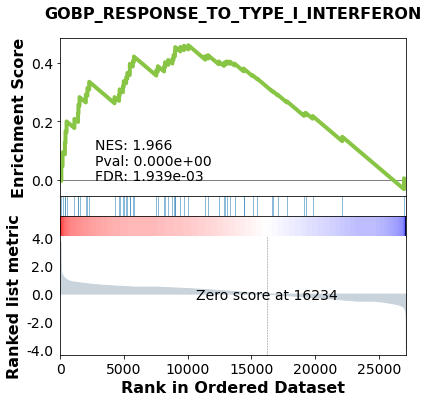

In [176]:
# WT: aPD1, None (positive control)
for c in case_list:
    tmp_case = list(gsea_PAK4WT_aPD1_d10.res2d[gsea_PAK4WT_aPD1_d10.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_PAK4WT_aPD1_d10.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_PAK4WT_aPD1_d10.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_PAK4WT_aPD1_d10.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_PAK4WT_aPD1_d10.ranking,
         term=gsea_PAK4WT_aPD1_d10.res2d.Term[tmp_case],
         **gsea_PAK4WT_aPD1_d10.results[gsea_PAK4WT_aPD1_d10.res2d.Term[tmp_case]])

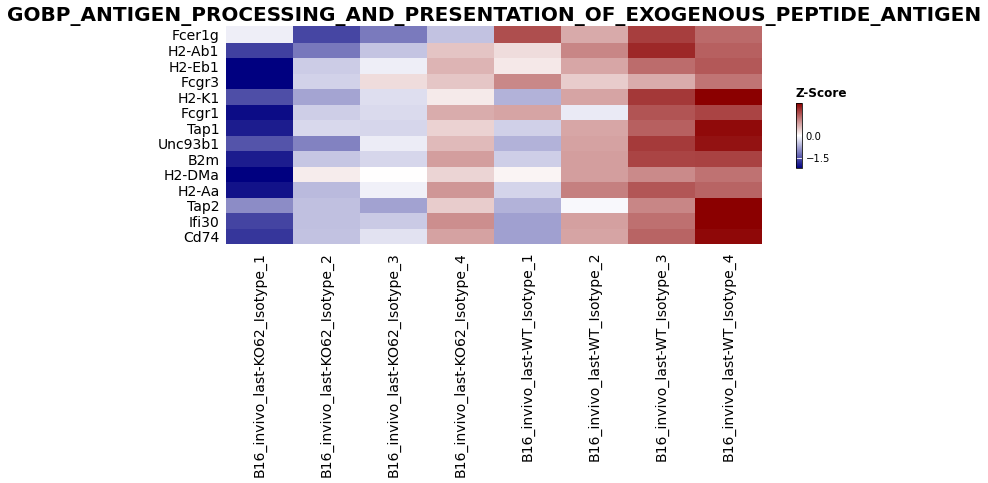

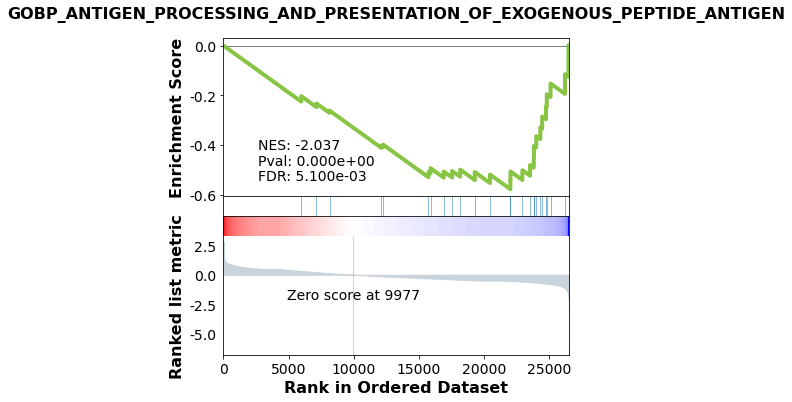

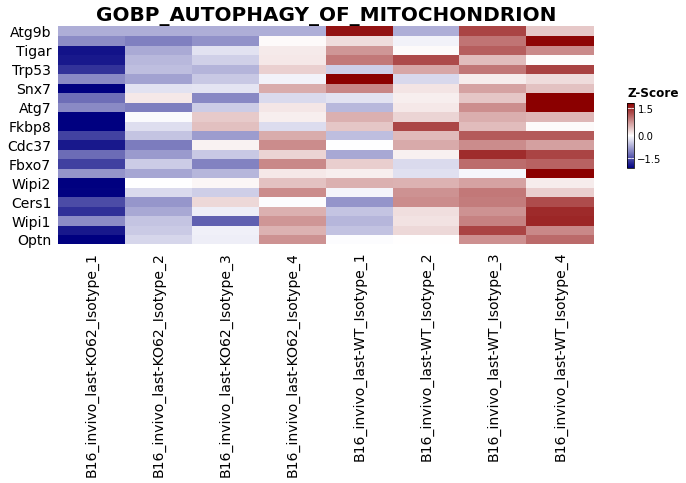

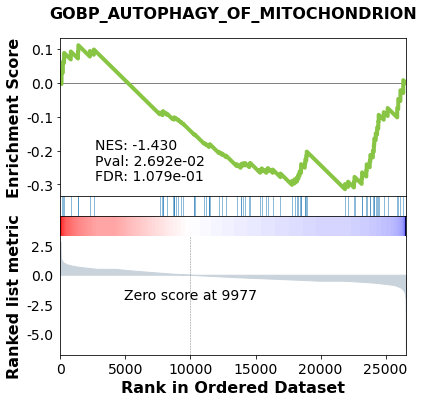

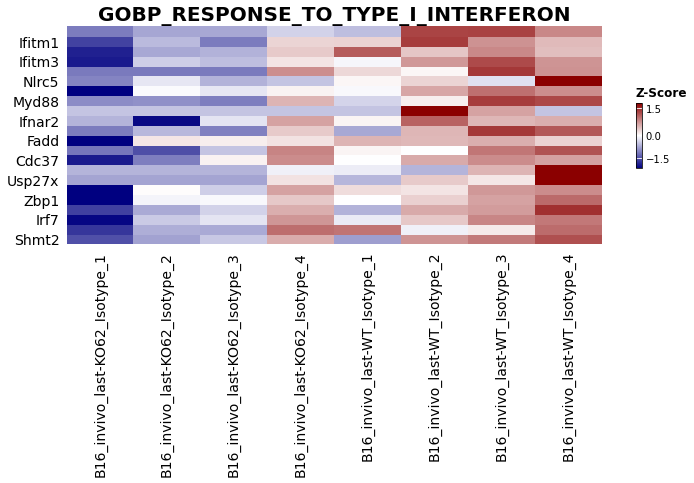

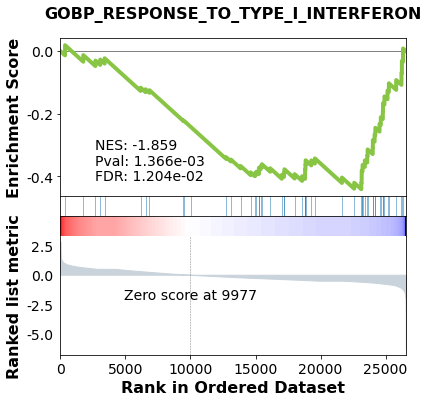

In [174]:
# iso: PAK4-KO, PAK4-WT
for c in case_list:
    tmp_case = list(gsea_PAK4KO_iso_d10.res2d[gsea_PAK4KO_iso_d10.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_PAK4KO_iso_d10.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_PAK4KO_iso_d10.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_PAK4KO_iso_d10.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_PAK4KO_iso_d10.ranking,
         term=gsea_PAK4KO_iso_d10.res2d.Term[tmp_case],
         **gsea_PAK4KO_iso_d10.results[gsea_PAK4KO_iso_d10.res2d.Term[tmp_case]])

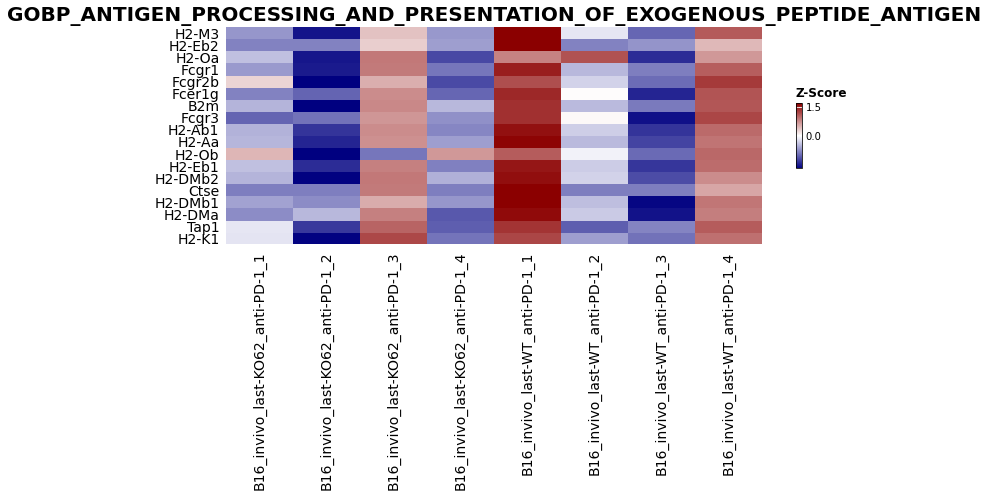

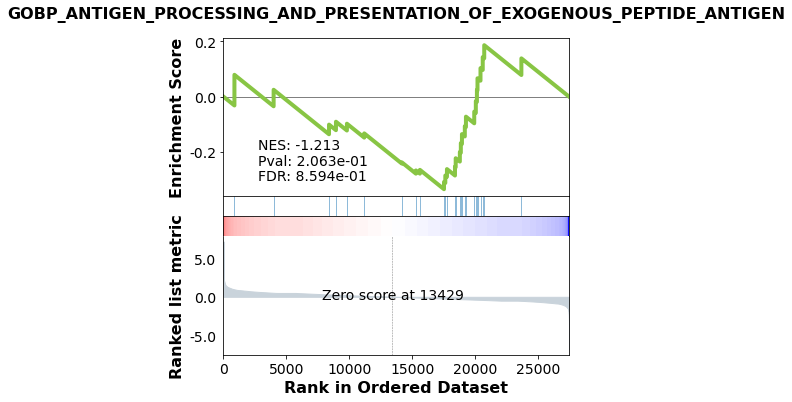

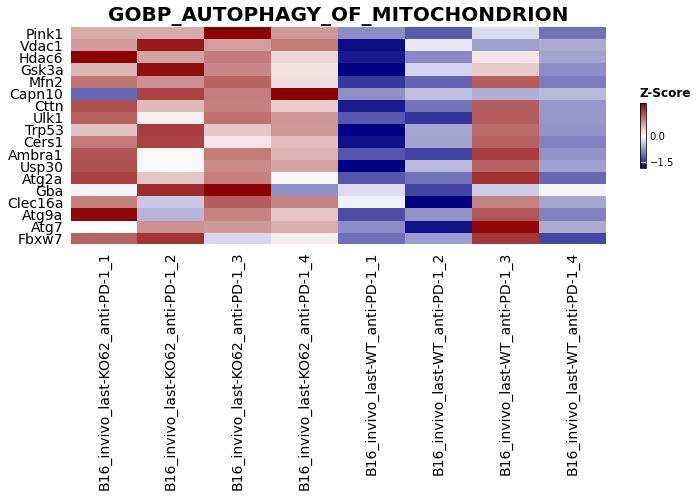

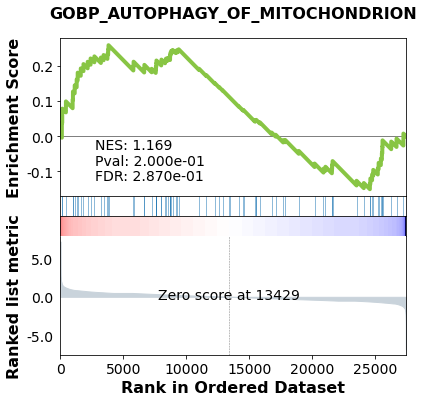

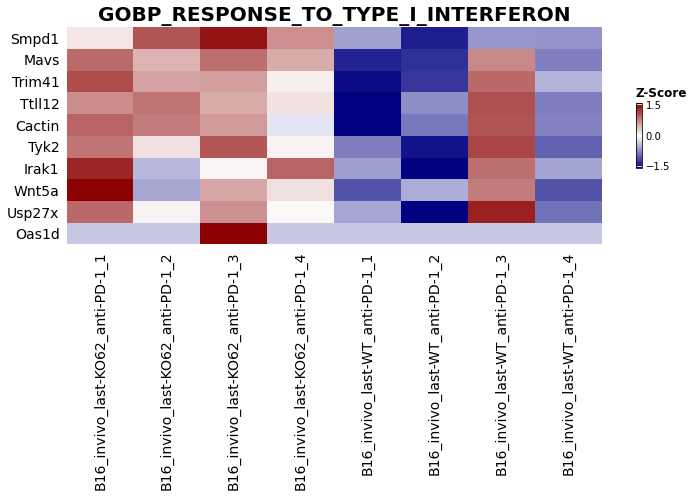

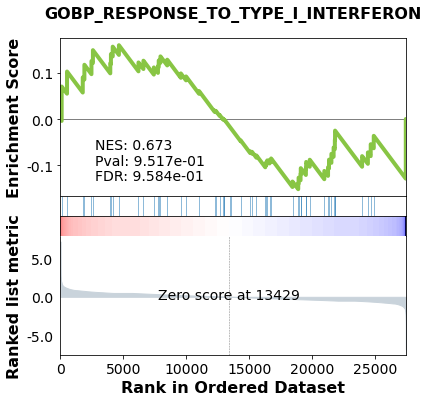

In [175]:
# aPD1: PAK4-KO, PAK4-WT
for c in case_list:
    tmp_case = list(gsea_PAK4KO_aPD1_d10.res2d[gsea_PAK4KO_aPD1_d10.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_PAK4KO_aPD1_d10.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_PAK4KO_aPD1_d10.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_PAK4KO_aPD1_d10.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_PAK4KO_aPD1_d10.ranking,
         term=gsea_PAK4KO_aPD1_d10.res2d.Term[tmp_case],
         **gsea_PAK4KO_aPD1_d10.results[gsea_PAK4KO_aPD1_d10.res2d.Term[tmp_case]])

In [ ]:
# old version

In [73]:
gsea_PAK4WT_aPD1_d10.res2d[gsea_PAK4WT_aPD1_d10.res2d['Term'] == 'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
170,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.73025,1.59336,0.0901804,0.542093,0.774,21/27,16.85%,H2-Oa;Tap2;Unc93b1;H2-DMb2;Ctss;H2-K1;Cd74;Cts...


In [74]:
gsea_PAK4KO_aPD1_d10.res2d[gsea_PAK4KO_aPD1_d10.res2d['Term'] == 'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3626,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,-0.333878,-0.690264,0.772,1,1,18/27,36.19%,H2-M3;H2-Eb2;H2-Oa;Fcgr1;Fcgr2b;Fcer1g;B2m;Fcg...


In [75]:
gsea_PAK4KO_iso_d10.res2d[gsea_PAK4KO_iso_d10.res2d['Term'] == 'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
84,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,-0.577824,-1.48064,0.095723,1,0.872,14/26,16.99%,Fcer1g;H2-Ab1;H2-Eb1;Fcgr3;H2-K1;Fcgr1;Tap1;Un...


<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN'}>

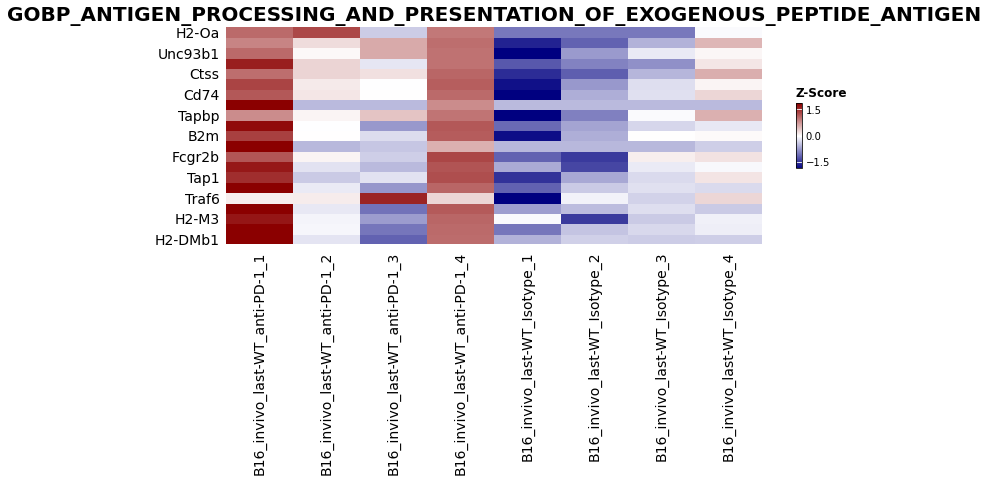

In [76]:
tmp_genes = gsea_PAK4WT_aPD1_d10.res2d.Lead_genes[170].split(';')
heatmap(df=gsea_PAK4WT_aPD1_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4WT_aPD1_d10.res2d.Term[170], figsize=(12, 4))

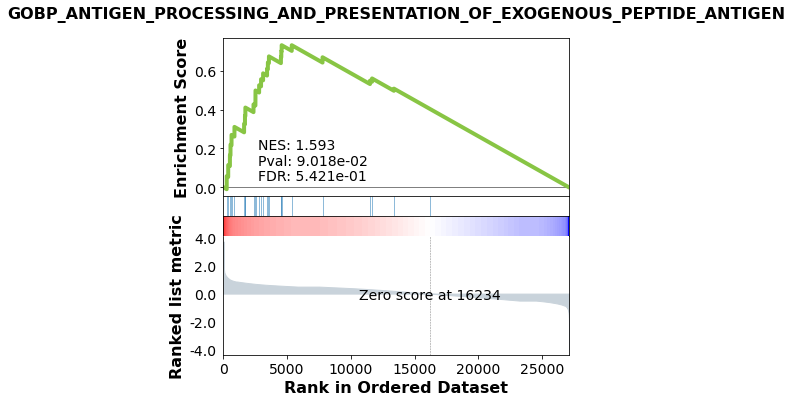

In [77]:
gseaplot(gsea_PAK4WT_aPD1_d10.ranking,
         term=gsea_PAK4WT_aPD1_d10.res2d.Term[170],
         **gsea_PAK4WT_aPD1_d10.results[gsea_PAK4WT_aPD1_d10.res2d.Term[170]])

<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN'}>

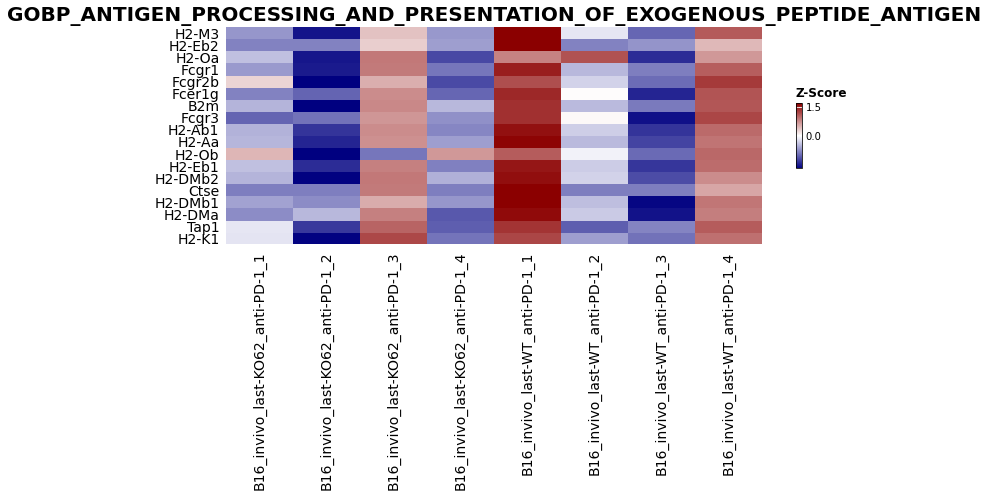

In [78]:
tmp_genes = gsea_PAK4KO_aPD1_d10.res2d.Lead_genes[3626].split(';')
heatmap(df=gsea_PAK4KO_aPD1_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_aPD1_d10.res2d.Term[3626], figsize=(12, 4))

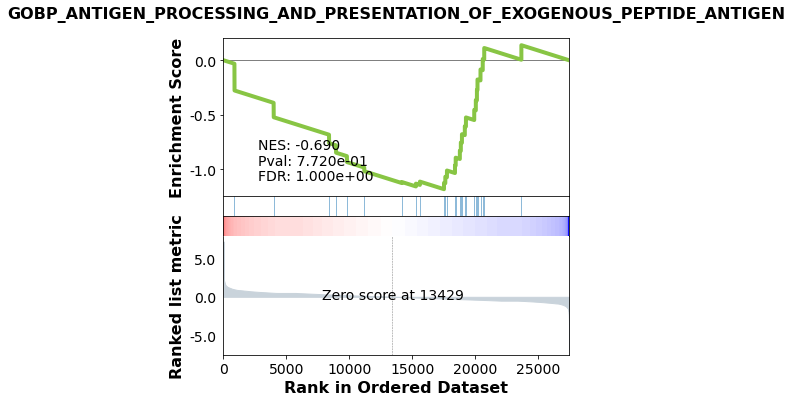

In [79]:
gseaplot(gsea_PAK4KO_aPD1_d10.ranking,
         term=gsea_PAK4KO_aPD1_d10.res2d.Term[3626],
         **gsea_PAK4KO_aPD1_d10.results[gsea_PAK4KO_aPD1_d10.res2d.Term[3626]])

<AxesSubplot:title={'center':'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN'}>

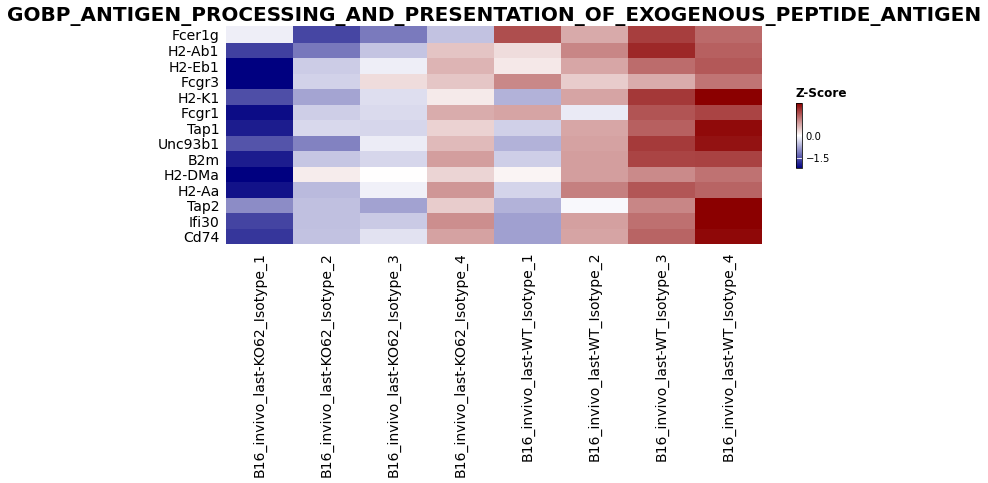

In [80]:
tmp_genes = gsea_PAK4KO_iso_d10.res2d.Lead_genes[84].split(';')
heatmap(df=gsea_PAK4KO_iso_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_iso_d10.res2d.Term[84], figsize=(12, 4))

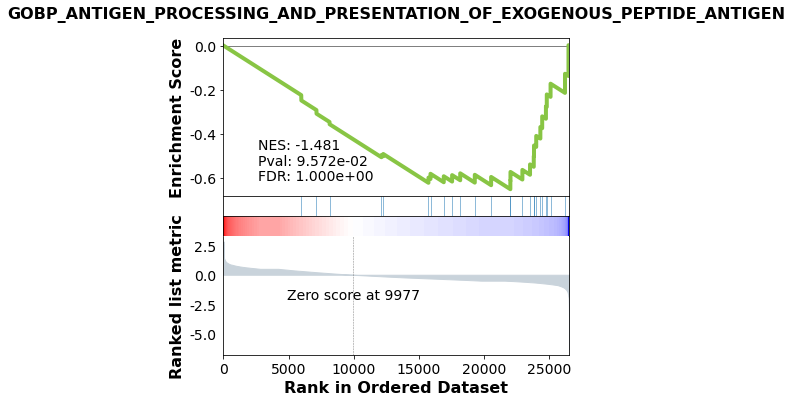

In [81]:
gseaplot(gsea_PAK4KO_iso_d10.ranking,
         term=gsea_PAK4KO_iso_d10.res2d.Term[84],
         **gsea_PAK4KO_iso_d10.results[gsea_PAK4KO_iso_d10.res2d.Term[84]])

In [82]:
gsea_PAK4WT_aPD1_d10.res2d[gsea_PAK4WT_aPD1_d10.res2d['Term'] == 'GOBP_AUTOPHAGY_OF_MITOCHONDRION']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
3452,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,0.20856,0.899558,0.628998,0.697763,1,47/80,47.77%,Smurf1;Atg3;Clec16a;Usp30;Dnm1l;Ogt;Slc25a46;O...


In [83]:
gsea_PAK4KO_aPD1_d10.res2d[gsea_PAK4KO_aPD1_d10.res2d['Term'] == 'GOBP_AUTOPHAGY_OF_MITOCHONDRION']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
1890,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,0.259067,1.15557,0.220273,0.611438,1,40/80,34.25%,Pink1;Vdac1;Hdac6;Gsk3a;Mfn2;Capn10;Cttn;Ulk1;...


In [84]:
gsea_PAK4KO_iso_d10.res2d[gsea_PAK4KO_iso_d10.res2d['Term'] == 'GOBP_AUTOPHAGY_OF_MITOCHONDRION']

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2682,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,-0.313919,-0.937052,0.693548,0.839856,1,47/80,48.94%,Atg9b;Becn1;Tigar;Phb2;Trp53;Snx30;Snx7;Hk2;At...


<AxesSubplot:title={'center':'GOBP_AUTOPHAGY_OF_MITOCHONDRION'}>

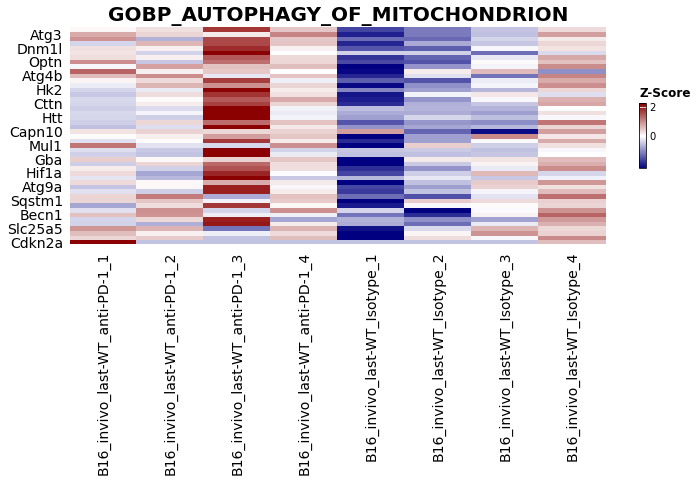

In [85]:
tmp_genes = gsea_PAK4WT_aPD1_d10.res2d.Lead_genes[3452].split(';')
heatmap(df=gsea_PAK4WT_aPD1_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4WT_aPD1_d10.res2d.Term[3452], figsize=(12, 4))

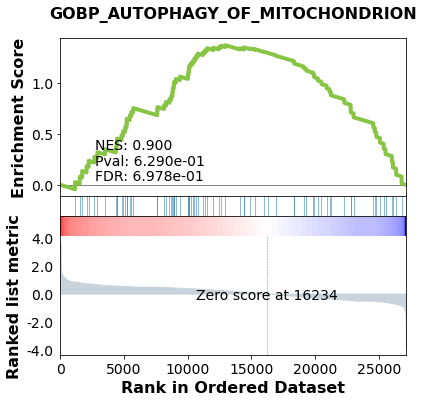

In [86]:
gseaplot(gsea_PAK4WT_aPD1_d10.ranking,
         term=gsea_PAK4WT_aPD1_d10.res2d.Term[3452],
         **gsea_PAK4WT_aPD1_d10.results[gsea_PAK4WT_aPD1_d10.res2d.Term[3452]])

<AxesSubplot:title={'center':'GOBP_AUTOPHAGY_OF_MITOCHONDRION'}>

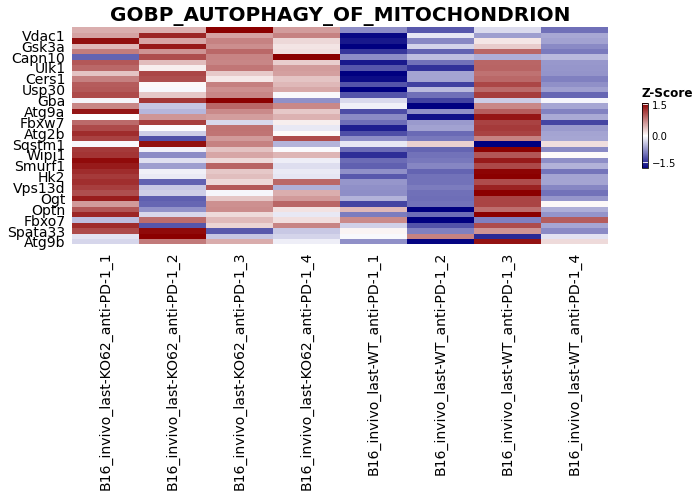

In [87]:
tmp_genes = gsea_PAK4KO_aPD1_d10.res2d.Lead_genes[1890].split(';')
heatmap(df=gsea_PAK4KO_aPD1_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_aPD1_d10.res2d.Term[1890], figsize=(12, 4))

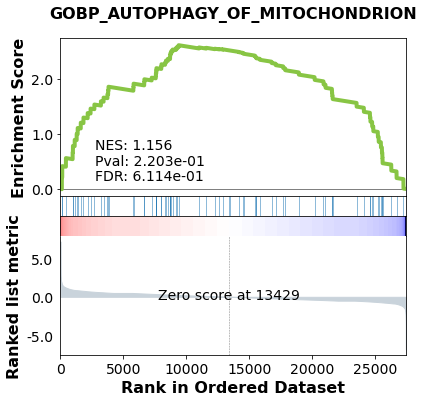

In [88]:
gseaplot(gsea_PAK4KO_aPD1_d10.ranking,
         term=gsea_PAK4KO_aPD1_d10.res2d.Term[1890],
         **gsea_PAK4KO_aPD1_d10.results[gsea_PAK4KO_aPD1_d10.res2d.Term[1890]])

<AxesSubplot:title={'center':'GOBP_AUTOPHAGY_OF_MITOCHONDRION'}>

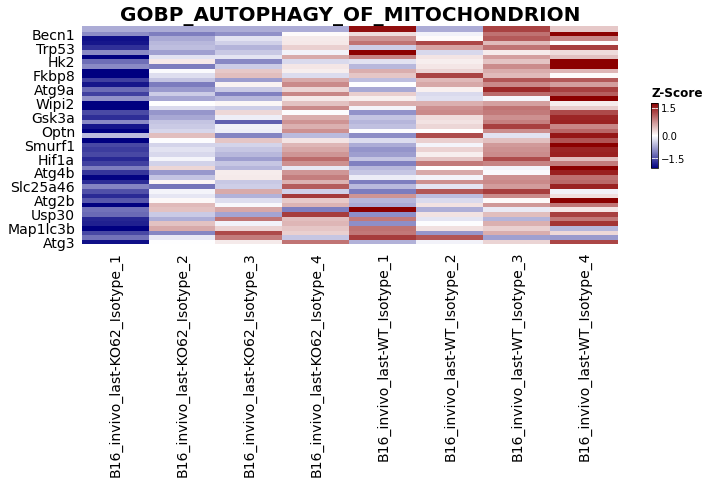

In [89]:
tmp_genes = gsea_PAK4KO_iso_d10.res2d.Lead_genes[2682].split(';')
heatmap(df=gsea_PAK4KO_iso_d10.heatmat.loc[tmp_genes],
        z_score=0, title=gsea_PAK4KO_iso_d10.res2d.Term[2682], figsize=(12, 4))

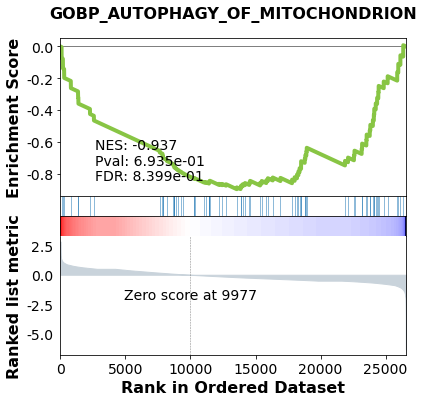

In [90]:
gseaplot(gsea_PAK4KO_iso_d10.ranking,
         term=gsea_PAK4KO_iso_d10.res2d.Term[2682],
         **gsea_PAK4KO_iso_d10.results[gsea_PAK4KO_iso_d10.res2d.Term[2682]])

## 3. PAK4i in vivo

In [91]:
pak4i_invivo

,group
WT_Combo_1,WT_Combo
WT_Combo_2,WT_Combo
WT_Combo_3,WT_Combo
WT_ISO_1_2,WT_ISO
WT_ISO_2_2,WT_ISO
WT_ISO_3_2,WT_ISO
WT_PAK4i_1,WT_PAK4i
WT_PAK4i_2,WT_PAK4i
WT_PAK4i_3,WT_PAK4i
WT_PD_1_2,WT_PD


In [92]:
pak4i_invivo_expr

,WT_Combo_1,WT_Combo_2,WT_Combo_3,WT_ISO_1_2,WT_ISO_2_2,WT_ISO_3_2,WT_PAK4i_1,WT_PAK4i_2,WT_PAK4i_3,WT_PD_1_2,WT_PD_2_2,WT_PD_3_2
Gene Name,,,,,,,,,,,,
0610005C13Rik,0.125857,0.157945,0.230459,0.166763,0.055293,0.086657,0.054787,0.172573,0.280640,0.090767,0.314558,0.095025
0610009B22Rik,4.650074,4.507256,4.304864,4.412285,4.432128,4.515269,4.402044,4.385927,4.370149,4.221292,4.596006,4.305097
0610009E02Rik,0.375520,0.634076,0.452909,0.394643,0.709107,0.235131,0.293933,0.513466,0.645238,0.483606,0.236569,0.406039
0610009L18Rik,2.235203,1.896757,1.400141,1.878352,2.353145,1.840576,1.658360,1.463041,1.467295,1.346176,1.895671,2.170513
0610010F05Rik,3.453604,3.629003,3.185566,3.230021,3.161185,2.953443,3.311503,3.661730,3.866629,3.014673,3.381792,3.585705
...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s85,0.665395,0.543065,0.036083,0.000000,0.192276,0.000000,0.181408,0.292234,0.577680,0.430591,0.606838,0.337010
n-R5s87,0.792026,0.245518,0.769666,0.000000,0.000000,0.000000,0.115554,0.000000,0.531997,0.174902,0.278759,0.000000
n-R5s88,0.000000,0.000000,0.000000,0.177839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 3.1 Prepare matrix

In [93]:
# iso: PAK4i, iso
expr_PAK4i_iso, label_PAK4i_iso = prepare_compare(expr=pak4i_invivo_expr,
                                                  grpA=pak4i_invivo[pak4i_invivo['group'] == 'WT_PAK4i'].index,
                                                  grpB=pak4i_invivo[pak4i_invivo['group'] == 'WT_ISO'].index,
                                                  label_A='PAK4i', label_B='ISO', n_label=3)

(31429, 6)


In [94]:
# iso: aPD1, iso
expr_aPD1_iso, label_aPD1_iso = prepare_compare(expr=pak4i_invivo_expr,
                                                grpA=pak4i_invivo[pak4i_invivo['group'] == 'WT_PD'].index,
                                                grpB=pak4i_invivo[pak4i_invivo['group'] == 'WT_ISO'].index,
                                                label_A='aPD1', label_B='ISO', n_label=3)

(31429, 6)


In [95]:
# combo vs pd1 alone
expr_combo_aPD1, label_combo_aPD1 = prepare_compare(expr=pak4i_invivo_expr,
                                                    grpA=pak4i_invivo[pak4i_invivo['group'] == 'WT_Combo'].index,
                                                    grpB=pak4i_invivo[pak4i_invivo['group'] == 'WT_PD'].index,
                                                    label_A='Combo', label_B='aPD1', n_label=3)

(31429, 6)


### 3.2 Run GSEA

In [146]:
# iso: PAK4i, iso
gsea_expr_PAK4i_iso = gp.gsea(data=expr_PAK4i_iso,
                              gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                              cls=label_PAK4i_iso,
                              permutation_type='gene_set',
                              permutaiton_num=1000,
                              threads=16, seed=0)

In [148]:
gc.collect()

20

In [138]:
# iso: aPD1, iso
gsea_expr_aPD1_iso = gp.gsea(data=expr_aPD1_iso,
                              gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                              cls=label_aPD1_iso,
                              permutation_type='gene_set',
                              permutaiton_num=1000,
                              threads=16, seed=0)

In [139]:
gc.collect()

20

In [137]:
# combo vs pd1 alone
gsea_expr_combo_aPD1 = gp.gsea(data=expr_combo_aPD1,
                               gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                               cls=label_combo_aPD1,
                               permutation_type='gene_set',
                               permutaiton_num=1000,
                               threads=16, seed=0)

In [140]:
gsea_expr_aPD1_iso.res2d.sort_values(by='NES', ascending=False)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
20,gsea,GOBP_AXON_ENSHEATHMENT_IN_CENTRAL_NERVOUS_SYSTEM,0.782099,2.39056,0.0125448,1,0.993,4/28,5.60%,Mal;B4galt5;Cntnap1;Pten
36,gsea,GOBP_POSITIVE_REGULATION_OF_EXTRINSIC_APOPTOTI...,0.874173,2.27954,0.0165441,1,0.998,1/15,0.05%,Mal
42,gsea,GOBP_REGULATION_OF_EXTRINSIC_APOPTOTIC_SIGNALI...,0.707428,2.23472,0.032646,1,0.999,1/45,0.05%,Mal
49,gsea,GOBP_OLIGODENDROCYTE_DEVELOPMENT,0.664109,2.13743,0.0280702,1,0.999,5/41,5.60%,Mal;B4galt5;Cntnap1;Tgfb1;Pten
63,gsea,GOBP_POSITIVE_REGULATION_OF_EXTRINSIC_APOPTOTI...,0.60222,1.99845,0.0389171,1,0.999,1/57,0.05%,Mal
...,...,...,...,...,...,...,...,...,...,...
4,gsea,GOBP_AEROBIC_RESPIRATION,-0.69344,-2.87808,0.0116618,1,0.436,102/177,14.98%,Ndufa9;Pdhb;Sdhb;Cox5a;Ndufa8;Cox7a2;Atp5j2;Ga...
3,gsea,GOBP_CYTOPLASMIC_TRANSLATION,-0.714518,-2.8876,0.00864553,1,0.433,84/143,13.82%,Rpl30;Rps25;Rps5;Rpl4;Rpl7;Rpl13;Eif3m;Rpl18a;...
2,gsea,GOBP_TRANSLATION_AT_SYNAPSE,-0.829875,-2.89971,0.00238663,1,0.431,38/48,13.82%,Rps5;Rpl4;Rpl35;Rpl7;Rpl13;Rpl23a;Rpl37a;Eef2;...
1,gsea,GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS,-0.794613,-2.94173,0.00515464,1,0.428,46/66,13.86%,Ndufa9;Sdhb;Ndufa8;Atp5j2;Dnajc30;Ndufa12;Nduf...


<AxesSubplot:xlabel='NES', ylabel='FDR q-val'>

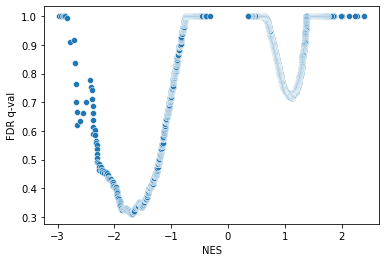

In [141]:
sns.scatterplot(x='NES', y='FDR q-val', data=gsea_expr_aPD1_iso.res2d)

### 3.3 Specific cases

In [149]:
gsea_expr_PAK4i_iso.res2d[gsea_expr_PAK4i_iso.res2d['Term'].isin(case_list)]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
2102,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,-0.320884,-1.11964,0.239923,0.707094,1,27/80,15.36%,Vdac1;Gsk3a;Map1lc3a;Tomm7;Arfip2;Phb2;Fbxo7;A...
2956,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,-0.320885,-0.936596,0.532328,0.890686,1,16/26,37.00%,Fcgr2b;H2-Ob;Tap2;Mfsd6;Tap1;H2-DMa;Tapbp;B2m;...
3889,gsea,GOBP_RESPONSE_TO_TYPE_I_INTERFERON,0.204287,0.682251,0.924242,0.957033,1,10/55,18.01%,Ythdf3;Wnt5a;Tbk1;Trim6;Irak1;Mul1;Smpd1;Setd2...


In [142]:
gsea_expr_aPD1_iso.res2d[gsea_expr_aPD1_iso.res2d['Term'].isin(case_list)]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
690,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,-0.355469,-1.32986,0.0846561,0.41622,1,24/80,12.74%,Bnip3l;Gabarapl1;Vdac1;Bnip3;Phb2;Slc25a5;Tomm...
940,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.425703,1.25135,0.15411,0.776439,1,23/27,48.93%,Pikfyve;H2-Eb2;H2-DMb2;Unc93b1;H2-M3;Traf6;H2-...
1038,gsea,GOBP_RESPONSE_TO_TYPE_I_INTERFERON,0.370358,1.22273,0.152429,0.757664,1,15/56,19.62%,Usp27x;Tyk2;Tbk1;Ikbke;Ythdf3;Irak1;Jak1;Trim5...


In [143]:
gsea_expr_combo_aPD1.res2d[gsea_expr_combo_aPD1.res2d['Term'].isin(case_list)]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
1158,gsea,GOBP_AUTOPHAGY_OF_MITOCHONDRION,0.370989,1.43217,0.0529661,0.195244,1,23/80,15.56%,Snx30;Vps13c;Smurf1;Vps13d;Ogt;Cdkn2a;Cttn;Ret...
1254,gsea,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,0.447198,1.39932,0.0873016,0.2097,1,25/27,51.95%,Mfsd6;Pikfyve;Fcgr3;Tapbp;Ctse;H2-K1;Ctss;H2-O...
2708,gsea,GOBP_RESPONSE_TO_TYPE_I_INTERFERON,0.290009,1.04452,0.364562,0.489467,1,17/57,21.26%,Jak1;Ythdf3;Ifnar1;Ikbke;Wnt5a;Trim56;Ifnb1;Mm...


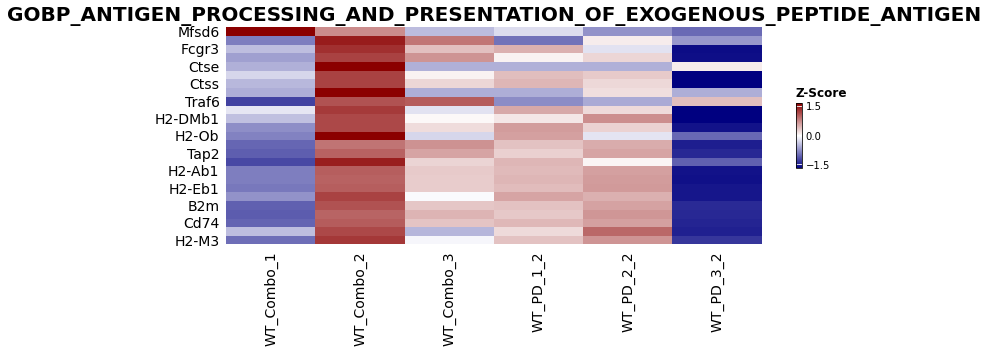

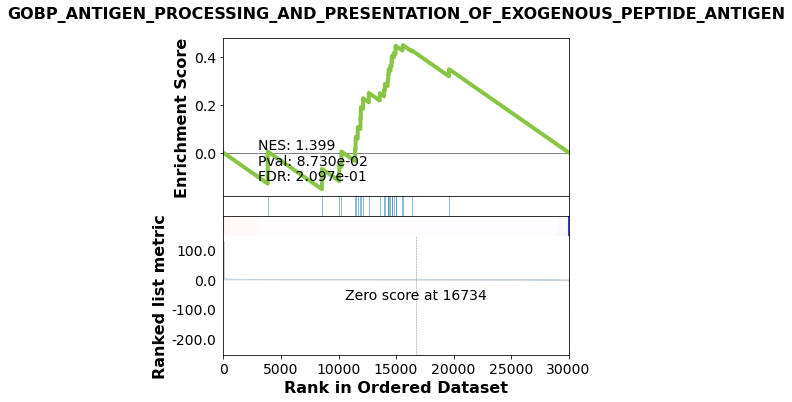

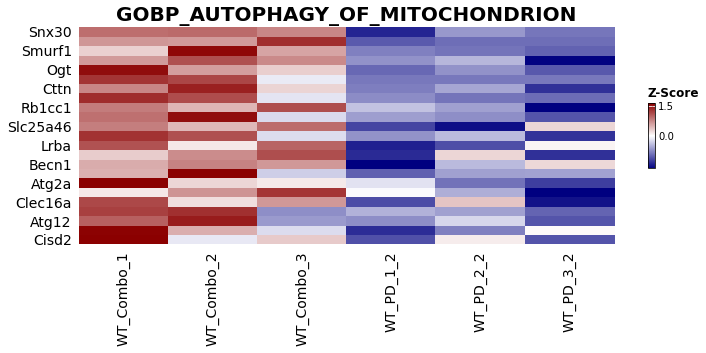

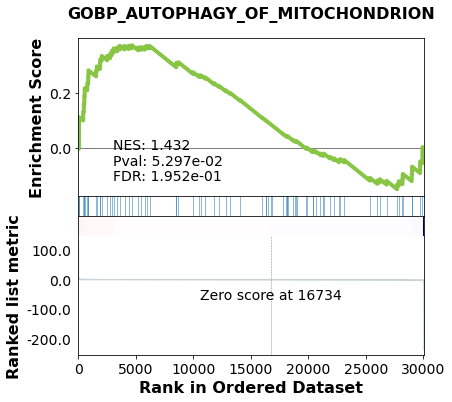

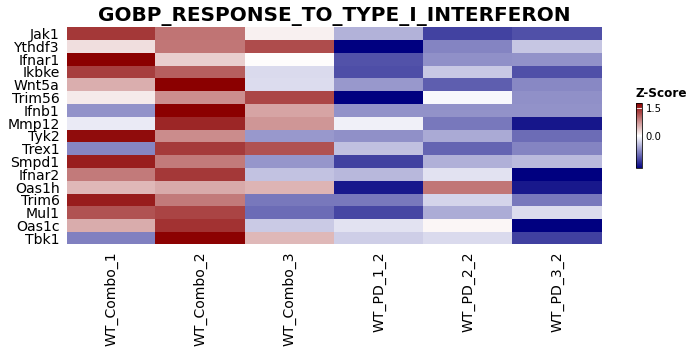

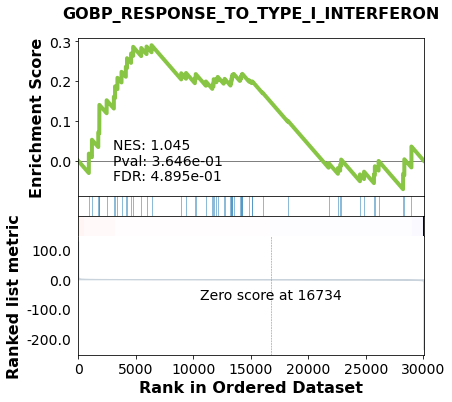

In [144]:
# Combo vs aPD1 alone
for c in case_list:
    tmp_case = list(gsea_expr_combo_aPD1.res2d[gsea_expr_combo_aPD1.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_expr_combo_aPD1.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_expr_combo_aPD1.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_expr_combo_aPD1.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_expr_combo_aPD1.ranking,
         term=gsea_expr_combo_aPD1.res2d.Term[tmp_case],
         **gsea_expr_combo_aPD1.results[gsea_expr_combo_aPD1.res2d.Term[tmp_case]])

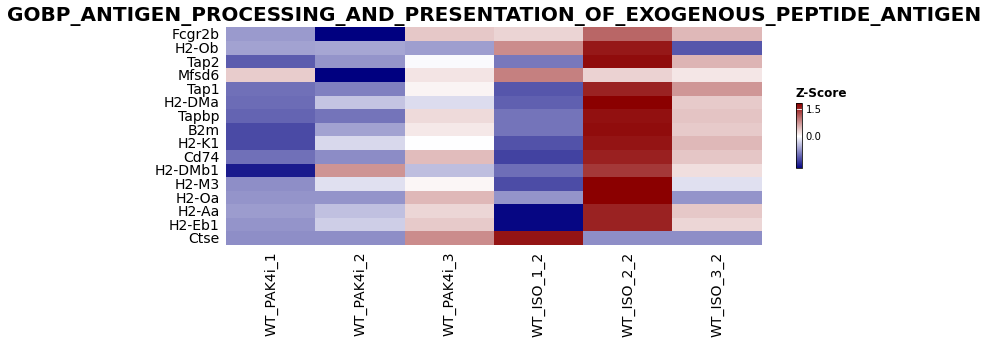

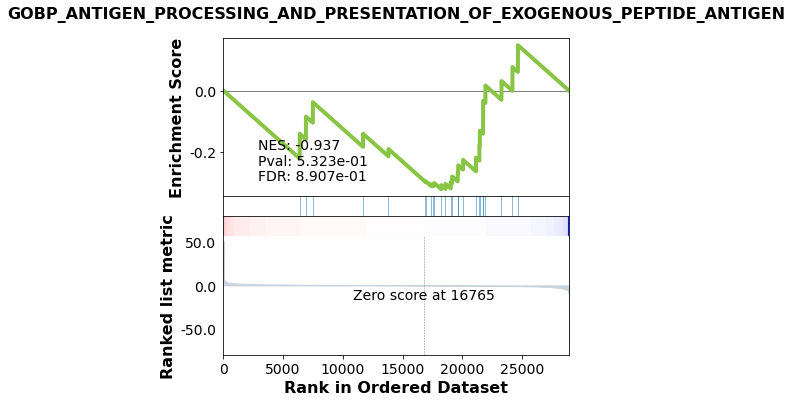

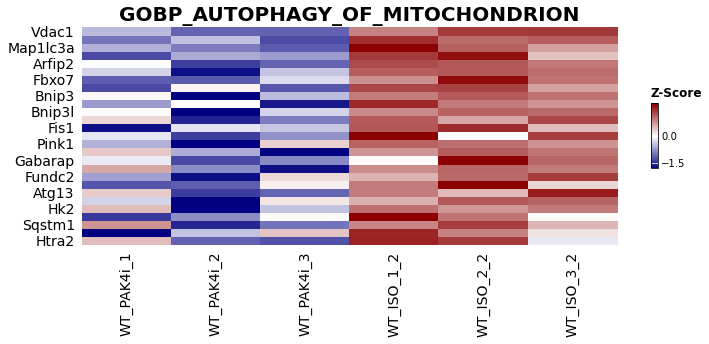

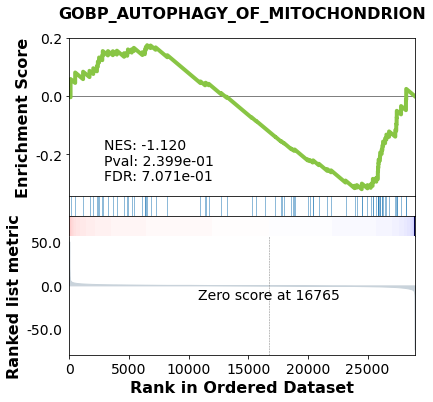

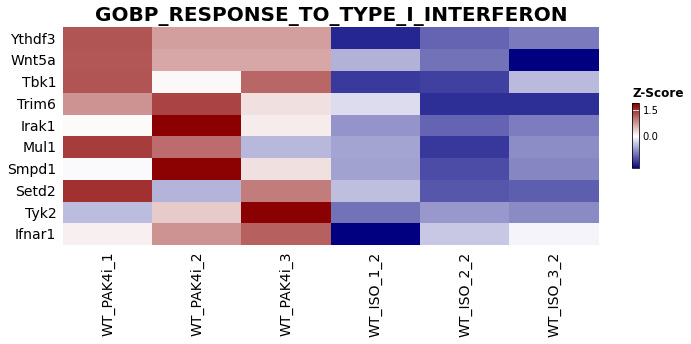

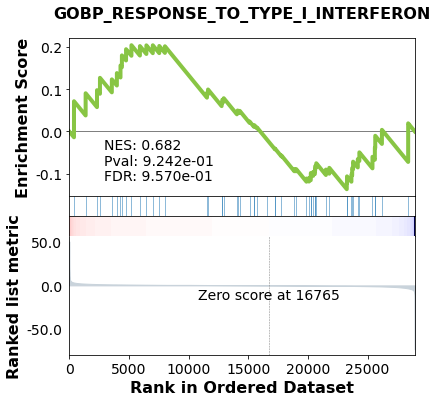

In [150]:
# PAK4i alone
for c in case_list:
    tmp_case = list(gsea_expr_PAK4i_iso.res2d[gsea_expr_PAK4i_iso.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_expr_PAK4i_iso.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_expr_PAK4i_iso.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_expr_PAK4i_iso.res2d.Term[tmp_case], figsize=(12, 4))
    gseaplot(gsea_expr_PAK4i_iso.ranking,
         term=gsea_expr_PAK4i_iso.res2d.Term[tmp_case],
         **gsea_expr_PAK4i_iso.results[gsea_expr_PAK4i_iso.res2d.Term[tmp_case]])

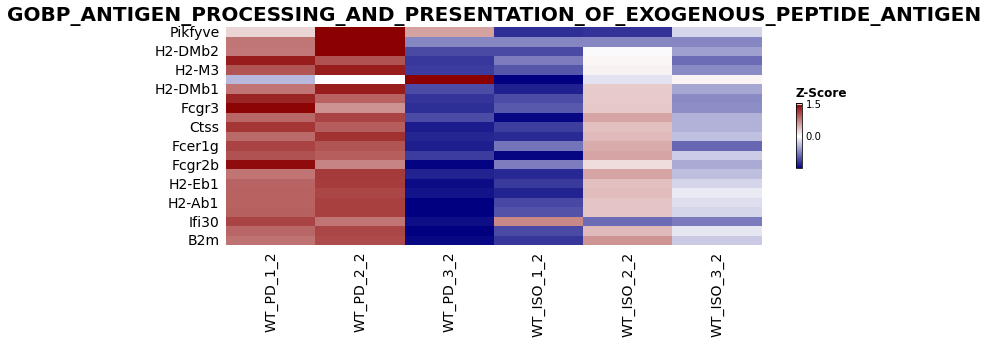

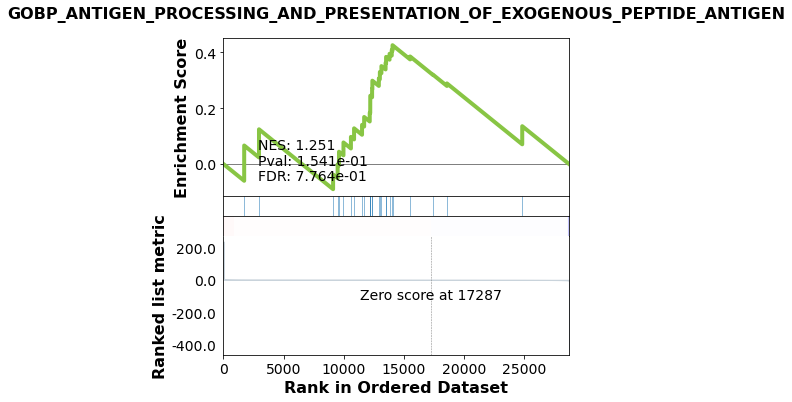

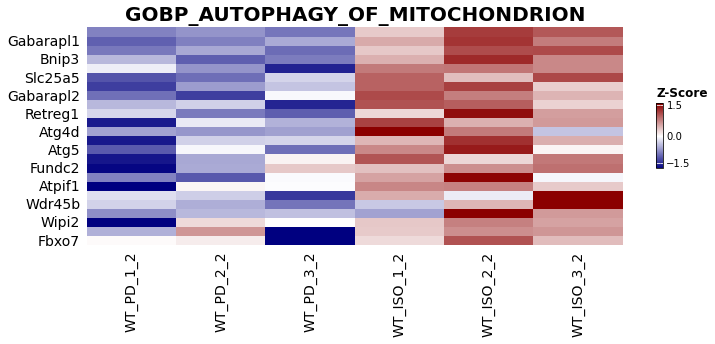

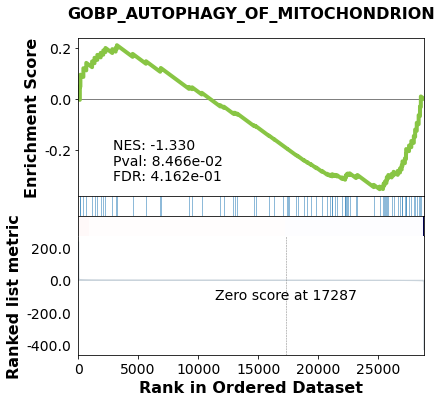

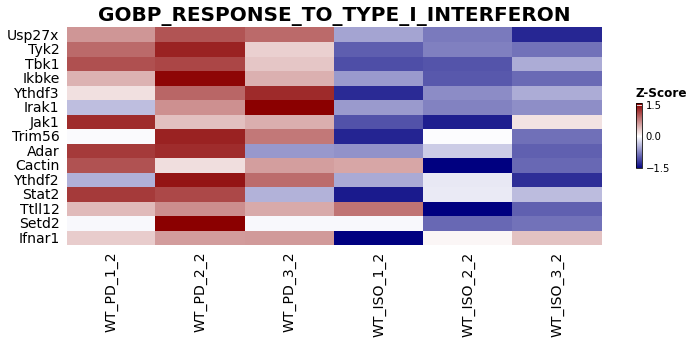

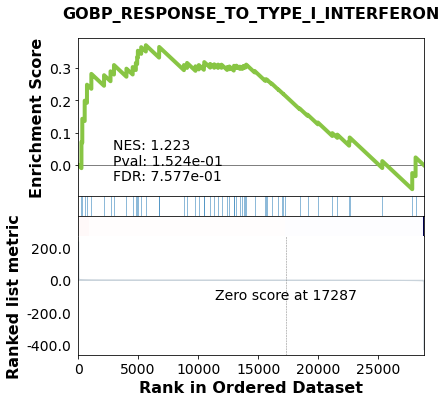

In [145]:
# aPD1 alone
for c in case_list:
    tmp_case = list(gsea_expr_aPD1_iso.res2d[gsea_expr_aPD1_iso.res2d['Term'] == c].index)[0]
    tmp_genes = gsea_expr_aPD1_iso.res2d.Lead_genes[tmp_case].split(';')
    heatmap(df=gsea_expr_aPD1_iso.heatmat.loc[tmp_genes],
            z_score=0, title=gsea_expr_aPD1_iso.res2d.Term[tmp_case], figsize=(12, 4))
    
    gseaplot(gsea_expr_aPD1_iso.ranking,
         term=gsea_expr_aPD1_iso.res2d.Term[tmp_case],
         **gsea_expr_aPD1_iso.results[gsea_expr_aPD1_iso.res2d.Term[tmp_case]])

# GSEA (EnrichR on DEG)

## 1. In vitro

In [ ]:
deg_invitro_media = pd.read_csv(result_home + 'PAK4KOvsWT_in_vitro_DEG_media.csv',
                                header=0, index_col=0, sep=',')
deg_invitro_media.head()

In [ ]:
deg_invitro_ifng = pd.read_csv(result_home + 'PAK4KOvsWT_in_vitro_DEG_ifng.csv',
                               header=0, index_col=0, sep=',')
deg_invitro_ifng.head()

In [ ]:
pak4_media_deg = deg_invitro_media[deg_invitro_media['t_p'] <= .05]
pak4_ifng_deg = deg_invitro_ifng[deg_invitro_ifng['t_p'] <= .05]
pak4_media_deg = pak4_media_deg[abs(pak4_media_deg['log2fc(tr-ct)']) >= .5]
pak4_ifng_deg = pak4_ifng_deg[abs(pak4_ifng_deg['log2fc(tr-ct)']) >= .5]

In [ ]:
pak4_media_up_enrich = gp.enrich(gene_list=list(pak4_media_deg[pak4_media_deg['log2fc(tr-ct)'] > 0].index),
                                  gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                                  outdir=None)


pak4_ifng_up_enrich = gp.enrich(gene_list=list(pak4_ifng_deg[pak4_ifng_deg['log2fc(tr-ct)'] > 0].index),
                                  gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                                  outdir=None)

pak4_media_down_enrich = gp.enrich(gene_list=list(pak4_media_deg[pak4_media_deg['log2fc(tr-ct)'] < 0].index),
                                      gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                                      outdir=None)


pak4_ifng_down_enrich = gp.enrich(gene_list=list(pak4_ifng_deg[pak4_ifng_deg['log2fc(tr-ct)'] < 0].index),
                                  gene_sets=gsea_home + 'gene_sets/m5.go.bp.v2023.1.Mm.symbols.gmt',
                                  outdir=None)

In [ ]:
pak4_ifng_down_enrich.results

In [ ]:
pak4_ifng_up_enrich.results

In [ ]:
pak4_media_down_enrich.results

In [ ]:
pak4_media_up_enrich.results

In [ ]:
barplot(pak4_media_up_enrich.results,
        column="Adjusted P-value",
        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
        size=10,
        top_term=10,
        figsize=(3,5),
        title = "PAK4 KO vs WT, up, media",
        xticklabels_rot=45, # rotate xtick labels
        show_ring=True, # set to False to revmove outer ring
        color='darkred')

In [ ]:
barplot(pak4_media_down_enrich.results,
        column="Adjusted P-value",
        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
        size=10,
        top_term=10,
        figsize=(3,5),
        title = "PAK4 KO vs WT, down, media",
        xticklabels_rot=45, # rotate xtick labels
        show_ring=True, # set to False to revmove outer ring
        color='darkblue')

In [ ]:
barplot(pak4_ifng_up_enrich.results,
        column="Adjusted P-value",
        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
        size=10,
        top_term=10,
        figsize=(3,5),
        title = "PAK4 KO vs WT, up, ifng",
        xticklabels_rot=45, # rotate xtick labels
        show_ring=True, # set to False to revmove outer ring
        color='darkred')

In [ ]:
barplot(pak4_ifng_down_enrich.results,
        column="Adjusted P-value",
        x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
        size=10,
        top_term=10,
        figsize=(3,5),
        title = "PAK4 KO vs WT, down, ifng",
        xticklabels_rot=45, # rotate xtick labels
        show_ring=True, # set to False to revmove outer ring
        color='darkblue')